In [1]:
name="PbPbPTB"

In [2]:
import os
import numpy as np
#import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

from multiprocessing import Pool
from multiprocessing import cpu_count

import time

### Setup working folders


In [3]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [4]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [5]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [6]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")
design_validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_validation_design")

In [7]:
#Simulation outputs at the design points
simulation_df = []
validation_df = []
simulation_sd_df = []
validation_sd_df = []
for idf in range(0,4):
    simulation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_{idf}"))
    validation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_validation_{idf}"))

    #simulation_sd_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_error_{idf}"))

In [8]:
prior_df

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
min,10.0,-0.7,0.3,0.5,0.000,0.3,-0.3,0.13,-2.0,-1.0,0.01,0.01,0.12,0.025,-0.8,2.0,0.130
max,20.0,0.7,2.0,1.5,4.913,2.0,0.3,0.30,1.0,2.0,0.20,0.20,0.30,0.150,0.8,8.0,0.165


In [9]:
design_validation.values[:,0]

array([16.61392, 14.69276, 13.4124 , 15.7191 , 18.35933, 14.81117,
       12.42332, 16.22187, 17.5077 , 12.39913, 15.30064, 16.30414,
       14.97793, 18.70076, 14.40436, 19.59232, 10.64583, 18.12531,
       17.3478 , 17.74874, 13.31123, 16.0584 , 19.85991, 15.02196,
       16.58522, 12.6464 , 10.73816, 11.47083, 16.43368, 15.20336,
       17.85092, 14.32179, 19.32355, 18.49966, 17.67419, 14.58312,
       19.64959, 15.56794, 17.49999, 13.00773, 10.02692, 12.29497,
       14.10919, 13.21823, 10.44843, 17.9209 , 15.94655, 15.68619,
       11.29837, 19.18794, 18.8771 , 17.25287, 10.95022, 17.13477,
       18.02028, 10.59224, 13.19245, 11.75608, 15.46842, 12.16548,
       13.91396, 12.83548, 11.33158, 19.93867, 15.13961, 13.50931,
       16.16121, 10.18216, 13.86766, 11.92168, 19.4547 , 14.26618,
       10.30879, 19.25724, 18.53628, 12.51142, 17.0482 , 18.26524,
       12.90043, 12.74872, 14.71588, 16.88647, 18.622  , 11.86245,
       15.89298, 14.01431])

In [10]:
df_clms=simulation_df[1].keys()

In [11]:
validation_df[1].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1579.065071,1248.785530,879.356765,565.266616,373.079357,223.237707,121.302304,58.922580,2220.987847,1908.960094,...,0.028396,0.034221,0.034276,0.029578,0.014398,0.012500,0.015869,0.017735,0.020967,0.020445
1,1420.266905,1208.205333,961.504497,658.693462,457.720607,301.995152,184.100804,97.061309,1944.896377,1758.163551,...,0.028318,0.031379,0.030959,0.037496,0.012169,0.011144,0.014129,0.014066,0.015816,0.016027
2,1271.039349,994.685408,722.768805,445.883941,267.229333,155.666229,69.992146,23.273763,1759.907823,1532.002886,...,0.032814,0.029251,0.029076,0.028250,0.010636,0.013618,0.014585,0.020335,0.020351,0.018187
3,1496.261786,1226.754444,944.628424,656.915121,438.967540,278.334785,149.007550,82.139332,2097.009023,1909.682633,...,0.023941,0.027086,0.029709,0.034274,0.010901,0.013839,0.015132,0.014378,0.017181,0.016049
4,1446.091667,1171.849333,858.639947,601.586459,416.940027,268.094157,151.448758,84.563672,1993.030103,1745.022253,...,0.025902,0.030062,0.032823,0.033640,0.011356,0.012977,0.015785,0.017052,0.020443,0.021477


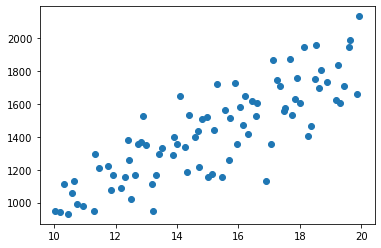

In [12]:
plt.scatter(design_validation.values[:,0],validation_df[0].values[:,0])

### Normalize all the other models using mean and variance of observable in the PbPb 2.76 TeV Grad model

In [13]:
#normalize data with respect to lower fidelity
s_l = StandardScaler()
x = simulation_df[0].values
s_l.fit(x)
for idf in range(0,4):
    x_tmp = simulation_df[idf].values
    simulation_df[idf]= pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)
    x_tmp_vl = validation_df[idf].values
    validation_df[idf]= pd.DataFrame(s_l.transform(x_tmp_vl),columns=df_clms)

#diff = np.array(prior_df.loc['max'].values - prior_df.loc['min'].values ).reshape(1,-1)
#diff_mat = np.repeat(diff,X.shape[0],axis=0)
#print(f'Shape of diff matt {diff_mat.shape}')
#X= np.divide(X,diff_mat)

In [14]:
validation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.588986,0.394747,0.019567,-0.195853,-0.159802,-0.268862,-0.371815,-0.364353,0.643844,0.471012,...,0.625800,0.699832,0.498501,0.075004,0.877382,-0.016224,0.608006,0.622871,0.853867,0.716252
1,-0.021078,0.189910,0.422538,0.420411,0.627382,0.823537,0.981015,0.984654,-0.002760,0.068560,...,0.436678,0.641225,0.245146,1.023181,0.322910,-0.005227,0.158573,-0.067812,0.186990,0.094650
2,-0.505571,-0.651470,-0.778166,-1.023470,-1.200025,-1.234706,-1.503294,-1.657287,-0.415992,-0.491116,...,1.088260,0.104371,0.136631,-0.026830,0.422139,0.913847,0.470842,0.555252,0.794429,0.512711
3,0.260646,0.261774,0.332504,0.402453,0.442852,0.490003,0.217992,0.443843,0.362159,0.436056,...,0.080744,0.015078,0.311495,0.573544,0.584673,0.656860,0.437586,0.125886,0.110186,0.071801
4,0.097701,0.031697,-0.094120,0.032235,0.257156,0.352534,0.277537,0.548922,0.117066,0.004021,...,0.145601,0.326421,0.380965,0.765455,0.559257,0.763450,0.443319,0.646920,0.761677,0.915353


In [15]:
simulation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.591637,0.513103,0.318624,0.271933,0.039116,-0.046547,-0.056316,-0.196780,0.312115,0.285345,...,0.264980,0.319903,0.324693,0.463557,0.106436,0.265152,0.327622,0.418780,0.429618,0.232612
1,-0.230583,-0.147812,0.027381,0.194263,-0.002001,0.081457,0.105784,0.179431,-0.536721,-0.433382,...,-0.030290,-0.272368,-0.140120,-0.342011,-0.143468,-0.347378,-0.186919,-0.368346,-0.429833,-0.506854
2,0.972523,0.963482,0.945805,0.885563,0.940180,0.949017,0.883270,0.806117,0.473958,0.514932,...,-0.666548,-0.737213,-0.796565,-0.605217,-0.379365,-0.427751,-0.886069,-0.845243,-0.812087,-0.761789
3,0.119161,0.086451,0.145753,0.281553,0.398146,0.463628,0.400291,0.308556,-0.065111,-0.033522,...,-0.852256,-0.773484,-0.507853,-0.498973,-0.687205,-0.593140,-0.518138,-0.659702,-0.545969,-0.622973
4,0.654355,0.792480,0.898200,0.836119,1.020304,1.056377,1.064235,1.049937,0.453101,0.453320,...,-0.009571,0.044080,-0.003329,0.008152,0.059327,-0.027168,-0.321039,-0.326921,-0.479888,-0.265960


In [16]:
X = design.values
X_vl = design_validation.values

In [17]:
for idf in range(0,4):
    Y = simulation_df[idf].values
    print('###########################\n for PbPb 2760')
    print( "X.shape : "+ str(X.shape) )
    print( "Y.shape : "+ str(Y.shape) )

    print('###########################\n for PbPb validation')
    Y_vl = validation_df[idf].values
    print( "X.shape : "+ str(X_vl.shape) )
    print( "Y.shape : "+ str(Y_vl.shape) )

###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)


In [18]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [19]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [20]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [21]:
observables_latex = ['$dN_{ch} / d\\eta$',
 '$dE_T / d\\eta$',
 '${dN_{\\pi}} / {dy}$',
 '${dN_{K}} / {dy}$',
 '${dN_{P}} / {dy}$',
 '$\\langle p_{T, \\pi} \\rangle$',
 '$\\langle p_{T, K} \\rangle$',
 '$\\langle p_{T, P} \\rangle$',
 '${\\delta p_T} / {\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

### Observables considered in this analysis

In [22]:
simulation_df[0].keys()

Index(['dNch_deta[0 5]', 'dNch_deta[ 5 10]', 'dNch_deta[10 20]',
       'dNch_deta[20 30]', 'dNch_deta[30 40]', 'dNch_deta[40 50]',
       'dNch_deta[50 60]', 'dNch_deta[60 70]', 'dET_deta[0.  2.5]',
       'dET_deta[2.5 5. ]',
       ...
       'v32[10 20]', 'v32[20 30]', 'v32[30 40]', 'v32[40 50]', 'v42[0 5]',
       'v42[ 5 10]', 'v42[10 20]', 'v42[20 30]', 'v42[30 40]', 'v42[40 50]'],
      dtype='object', length=110)

In [23]:
observables_choosen = ['dNch_deta[0 5]',
 'dNch_deta[60 70]',
 'dN_dy_pion[0 5]',
 'dN_dy_pion[60 70]',
# 'dN_dy_kaon[0 5]',
# 'dN_dy_kaon[60 70]',
# 'dN_dy_proton[0 5]',
# 'dN_dy_proton[60 70]',
 'mean_pT_pion[0 5]',
 'mean_pT_pion[60 70]',
# 'mean_pT_kaon[0 5]',
# 'mean_pT_kaon[60 70]',               
# 'mean_pT_proton[0 5]',
# 'mean_pT_proton[60 70]',
 'pT_fluct[0 5]',
 'pT_fluct[55 60]',
 'v22[0 5]',
  'v22[60 70]']

###  Build the source emulators and find length scales and white noise that we can use in multifidelity code to fix hyper parameters.

In [24]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
#from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib

In [25]:
GP_dic={}
n_opt = 10
n_proc=10
for selected_observable in observables_choosen:
    Y_l=simulation_df[0][selected_observable].values.reshape(-1,1)
    Y_h=simulation_df[3][selected_observable].values.reshape(-1,1)
    Y_v=validation_df[3][selected_observable].values.reshape(-1,1)
    
    x_train_h, x_test_h, y_train_h, y_test_h = X, X_vl, Y_h, Y_v
    x_train_l, y_train_l = X, Y_l
    print(selected_observable)
    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    low_gp_model = GPy.models.GPRegression(x_train_l,y_train_l, kernel)
        #high_gp_model.Gaussian_noise.fix(0)

        ## Fit the GP model
    
    low_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    print(low_gp_model)
    GP_dic[selected_observable]=low_gp_model

dNch_deta[0 5]
Optimization restart 1/10, f = -98.85465884193474
Optimization restart 2/10, f = -98.85516837452508
Optimization restart 3/10, f = -98.85502476007241
Optimization restart 4/10, f = -98.85467427928921
Optimization restart 5/10, f = -98.85512209754177
Optimization restart 6/10, f = -98.8550796831064
Optimization restart 7/10, f = -98.85515269796616
Optimization restart 8/10, f = -98.85507514872603
Optimization restart 9/10, f = -98.8551593334094
Optimization restart 10/10, f = -98.85505544885967

Name : GP regression
Objective : -98.85516837452508
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     4.076980036667794  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.006799397074812838  |      +ve      |        
dNch_deta[60 70]
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 16.173739140184637
Optimization restart 2/10, f = 16.172658095647705
Optimization restart 3/10, f = 3.048775519386851
Optimization restart 4/10, f = 0.9704107200155363
Optimization restart 5/10, f = 0.9623928098151566
Optimization restart 6/10, f = 0.8738986569921963
Optimization restart 7/10, f = 16.172176159042408
Optimization restart 8/10, f = 0.8734964356890487
Optimization restart 9/10, f = 0.7291518035568174
Optimization restart 10/10, f = 0.8444063996848286

Name : GP regression
Objective : 0.7291518035568174
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    2.2591726467224102  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.005950580626490287  |      +ve      |        
pT_fluct[0 5]
Optimization restart 1/10, f 

### Transfer Learning using Emukit

In [25]:
def run_train_and_validation(x_train_s, x_train_t, x_test_t, y_train_s, y_train_t, y_test_t, obs_name):
    print(obs_name)
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_s, x_train_t], [y_train_s, y_train_t])
    n_opt = 10
    n_proc = 10
    
    ## Construct a linear multi-fidelity model

    #kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    lin_tl_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_tl_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_tl_kernel, n_fidelities=2)
    
    #Set the parameters in the Source Gaussian Process
    
    rbf_l_scales = GP_dic[obs_name].rbf.lengthscale.values
    rbf_var = GP_dic[obs_name].rbf.variance.values[0]
    wn = GP_dic[obs_name].Gaussian_noise.variance.values[0]
    
    gpy_lin_tl_model.multifidelity.rbf.lengthscale.fix(value=rbf_l_scales)
    gpy_lin_tl_model.multifidelity.rbf.variance.fix(value=rbf_var)
    gpy_lin_tl_model.mixed_noise.Gaussian_noise.fix(wn)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_tl_model = GPyMultiOutputWrapper(gpy_lin_tl_model, 2, n_optimization_restarts=n_opt,
                                         parallel=True, num_processes=n_proc)

    ## Fit the model
    st_l = time.time()
    lin_tl_model.optimize()
    et_l = time.time()
    
    #print("parameter array provided")
    #print(f'{rbf_l_scales} noise {wn}')
    
    if np.allclose(lin_tl_model.gpy_model.multifidelity.rbf.lengthscale.values, rbf_l_scales):
          print('RBF lengthscales are the same for low fidelity after optimization')
    if wn == lin_tl_model.gpy_model.mixed_noise.Gaussian_noise.variance.values[0]:
          print('White noise are the same after optimization')
    print('parameter array of multifidelity linear')
    print(lin_tl_model.gpy_model.param_array)
    print(f'time for linear mf optimization {et_l-st_l}')
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    sd_gp_model = GPy.models.GPRegression(x_train_t,y_train_t, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    sd_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    
    x_temp = convert_x_list_to_array([x_test_t,x_test_t])
    x_test_t_idf_index = x_temp[x_test_t.shape[0]:,:]
    x_test_s_idf_index = x_temp[0:x_test_t.shape[0],:]
    
    
    #Transfer learning predictions and validation score calculations
    t_mean_lin_tl_model, t_var_lin_tl_model = lin_tl_model.predict(x_test_t_idf_index)
    s_mean_lin_tl_model, s_var_lin_tl_model = lin_tl_model.predict(x_test_s_idf_index)


    print(t_mean_lin_tl_model.shape)
    r2_tl = r2_score(y_test_t,t_mean_lin_tl_model )
    mse_tl = mean_squared_error(y_test_t,t_mean_lin_tl_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_t,t_mean_lin_tl_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_t,t_mean_lin_tl_model )}')

    
    # Standard GP predicitons an validation score calculation
    t_mean_sd_gp_model, t_var_sd_gp_model  = sd_gp_model.predict(x_test_t)
    print(t_mean_sd_gp_model.shape)
    r2_sdgp = r2_score(y_test_t,t_mean_sd_gp_model)
    mse_sdgp = mean_squared_error(y_test_t,t_mean_sd_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_t,t_mean_sd_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_t,t_mean_sd_gp_model )}')
    
 
    lin_tl_normalized_residue = np.divide(np.array(t_mean_lin_tl_model-y_test_t).reshape(-1,1),np.sqrt(t_var_lin_tl_model.reshape(-1,1)))
   # nonlin_mf_normalize = np.divide(np.array(hf_mean_nonlin_mf_model-y_test_h).reshape(-1,1),np.sqrt(hf_var_nonlin_mf_model.reshape(-1,1))) 
    standard_gp_normalized_residue = np.divide(np.array(t_mean_sd_gp_model-y_test_t).reshape(-1,1),np.sqrt(t_var_sd_gp_model.reshape(-1,1))) 

    df_1 = pd.DataFrame.from_dict({'residue': lin_tl_normalized_residue.flatten(), 'name':'TL', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df_2 = pd.DataFrame.from_dict({'residue': standard_gp_normalized_residue.flatten(), 'name':'GP', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df = pd.concat(axis=0, ignore_index=True, objs=[df_1, df_2])
    
    r2s= [r2_tl, r2_sdgp]
    mses=[mse_tl, mse_sdgp]
    Wn = [lin_tl_model.gpy_model.param_array[-2],lin_tl_model.gpy_model.param_array[-1], sd_gp_model.param_array[-1]]
    rho = lin_tl_model.gpy_model.param_array[-3]
    return np.hstack((r2s, mses, Wn, rho)), df

Uncomment the following block if you want to run and calculate residues.



In [27]:
# residue_df = pd.DataFrame()
# n_batch = 10
# df_results = pd.DataFrame(columns=["observable", "fold","n_training","r2_lin_tl","r2_stand_GP",
#                                   "mse_lin_tl","mse_stand_GP","wn_lin_tl","wn_stand_GP","rho"])
# split_i = 0
# for selected_observable in observables_choosen:
#     start_time = time.time()
#     Y_s=simulation_df[0][selected_observable].values.reshape(-1,1)
#     Y_t=simulation_df[3][selected_observable].values.reshape(-1,1)
#     Y_v=validation_df[3][selected_observable].values.reshape(-1,1)
    
#     x_train_t, x_test_t, y_train_t, y_test_t = X, X_vl, Y_t, Y_v
#     x_train_s, y_train_s = X, Y_s
    
#     for i in range(0,n_batch):
#         if i in [0,1,2,3,4,5,6,7,8,9]:
#             l=0
#             h=(x_train_t.shape[0]//n_batch)*(i+1)
#         else:
#             continue
#         if i == n_batch-1:
#             h=x_train_t.shape[0]
#         r2_mse_wn_rho, df_tmp = run_train_and_validation(x_train_s, x_train_t[l:h,:],x_test_t, y_train_s, y_train_t[l:h,:], y_test_t, selected_observable)
#         df_results = df_results.append({
#                 "observable": selected_observable,
#                 "fold": split_i,
#                 "n_training":h,
#                 "r2_lin_mf":r2_mse_wn_rho[0],
#                 "r2_stand_GP":r2_mse_wn_rho[1],
#                 "mse_lin_mf":r2_mse_wn_rho[2],
#                 "mse_stand_GP":r2_mse_wn_rho[3],
#                 "wn_lin_mf_0":r2_mse_wn_rho[4],
#                 "wn_lin_mf_1":r2_mse_wn_rho[5],
#                 "wn_stand_GP":r2_mse_wn_rho[6],
#                 "rho":r2_mse_wn_rho[7]}, ignore_index=True)
#         if residue_df.empty:
#             residue_df = df_tmp
#         else:
#             residue_df = pd.concat(axis=0, ignore_index=True, objs=[residue_df, df_tmp])
#     end_time =time.time()
#     print(f'Time it take for {selected_observable} is {end_time-start_time}')
# #    time_ar.append(end_time-start_time)
# #time_ar= np.array(time_ar)
#residue_df.to_csv(name+'_residue')
#df_results.to_csv(name)

########################
dNch_deta[0 5]
Optimization restart 1/10, f = -136.59992582246394
Optimization restart 2/10, f = -137.05862498605694
Optimization restart 3/10, f = -137.0600167060598
Optimization restart 4/10, f = -135.06447478788408
Optimization restart 5/10, f = -137.0585134854083
Optimization restart 6/10, f = -137.0549045722753
Optimization restart 7/10, f = -135.05388946974045
Optimization restart 8/10, f = -135.05264277066203
Optimization restart 9/10, f = -137.01855166427953
Optimization restart 10/10, f = -137.06001972874907
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07698004e+00 1.74713538e+01 4.19825697e+00 5.20407235e+00
 2.05714419e+00 9.01185537e+01 2.30673044e+00 1.37022018e+00
 4.84552512e-01 2.01991377e+01 3.40053643e+00 8.01528607e-01
 4.25905457e-01 2.15699301e-01 4.73247695e-01 3.64671031e+00
 7.76359665e+01 2.74586245e-01 1.08336686e+00 2.09559308e+

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -4.680029327617895
Optimization restart 2/10, f = 1.3494052295087329
Optimization restart 3/10, f = -4.678781998220025
Optimization restart 4/10, f = -4.678185312536549
Optimization restart 5/10, f = 1.349403652841481
Optimization restart 6/10, f = -4.677621543715283
Optimization restart 7/10, f = 1.3494026281685336
Optimization restart 8/10, f = -4.680091961247648
Optimization restart 9/10, f = 1.349404053256528
Optimization restart 10/10, f = -4.67911975293876
(86, 1)
r2 score for multifidelity linear 0.9641194079879413
mse for multifidelity linear 0.04938508642902925
(86, 1)
r2 score for standard GP 0.936561423907663
mse for standard GP 0.08731515807213287
########################
dNch_deta[0 5]
Optimization restart 1/10, f = -206.5295777379755
Optimization restart 2/10, f = -182.03747228980376
Optimization restart 3/10, f = -181.35666339466775
Optimization restart 4/10, f = -206.40608698126783
Optimization restart 5/10, f = -205.94034866270908
Optimiz

Optimization restart 1/10, f = -9.655272148027194
Optimization restart 2/10, f = -9.655275555018193
Optimization restart 3/10, f = -9.655270829717153
Optimization restart 4/10, f = 33.74762572741926
Optimization restart 5/10, f = -9.655275847859457
Optimization restart 6/10, f = -9.655154346331017
Optimization restart 7/10, f = 33.74764465308186
Optimization restart 8/10, f = -9.654530069601947
Optimization restart 9/10, f = -9.655200883012327
Optimization restart 10/10, f = -9.655166982775285
(86, 1)
r2 score for multifidelity linear 0.975743531169142
mse for multifidelity linear 0.033385954425511885
(86, 1)
r2 score for standard GP 0.9625597299792532
mse for standard GP 0.051531785492261804
########################
dNch_deta[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -367.3089511461169
Optimization restart 2/10, f = -367.3178420288399
Optimization restart 3/10, f = -367.31892581359017
Optimization restart 4/10, f = -367.31834882816634
Optimization restart 5/10, f = -367.3188539633257
Optimization restart 6/10, f = -367.31896828667334
Optimization restart 7/10, f = -367.3161249714089
Optimization restart 8/10, f = -367.30939220857846
Optimization restart 9/10, f = -367.31850589233545
Optimization restart 10/10, f = -363.3470211699838
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07698004e+00 1.74713538e+01 4.19825697e+00 5.20407235e+00
 2.05714419e+00 9.01185537e+01 2.30673044e+00 1.37022018e+00
 4.84552512e-01 2.01991377e+01 3.40053643e+00 8.01528607e-01
 4.25905457e-01 2.15699301e-01 4.73247695e-01 3.64671031e+00
 7.76359665e+01 2.74586245e-01 2.26247344e-01 2.86475499e+01
 1.87597234e+04 2.05400928e+04 8.314718

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -447.0479178897889
Optimization restart 2/10, f = -447.04876789404904
Optimization restart 3/10, f = -447.0483354302751
Optimization restart 4/10, f = -447.0485933311675
Optimization restart 5/10, f = -369.53346449716264
Optimization restart 6/10, f = -447.04704578672437
Optimization restart 7/10, f = -395.42427232453167
Optimization restart 8/10, f = -447.0455091555044
Optimization restart 9/10, f = -369.09368112935226
Optimization restart 10/10, f = -447.0481596238549
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07698004e+00 1.74713538e+01 4.19825697e+00 5.20407235e+00
 2.05714419e+00 9.01185537e+01 2.30673044e+00 1.37022018e+00
 4.84552512e-01 2.01991377e+01 3.40053643e+00 8.01528607e-01
 4.25905457e-01 2.15699301e-01 4.73247695e-01 3.64671031e+00
 7.76359665e+01 2.74586245e-01 2.21728104e-01 2.81107386e+01
 5.57414378e+03 7.87095281e+03 7.852472

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -489.84989540379854
Optimization restart 2/10, f = -489.917651535431
Optimization restart 3/10, f = -403.52903974618073
Optimization restart 4/10, f = -490.21905689725264
Optimization restart 5/10, f = -491.70280544634346
Optimization restart 6/10, f = -491.6695486601558
Optimization restart 7/10, f = -491.6616942262934
Optimization restart 8/10, f = -491.6737528007459
Optimization restart 9/10, f = -474.6438214347748
Optimization restart 10/10, f = -491.6729115430602
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07698004e+00 1.74713538e+01 4.19825697e+00 5.20407235e+00
 2.05714419e+00 9.01185537e+01 2.30673044e+00 1.37022018e+00
 4.84552512e-01 2.01991377e+01 3.40053643e+00 8.01528607e-01
 4.25905457e-01 2.15699301e-01 4.73247695e-01 3.64671031e+00
 7.76359665e+01 2.74586245e-01 2.73702017e-01 2.75371753e+01
 5.21429173e+02 5.39286761e+02 8.65414712

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/da

Optimization restart 1/10, f = 91.27145700869625
Optimization restart 2/10, f = 91.51344874088272
Optimization restart 3/10, f = 92.44241760652636
Optimization restart 4/10, f = 91.54675666598962
Optimization restart 5/10, f = 91.5968546921028
Optimization restart 6/10, f = 91.10668708989522
Optimization restart 7/10, f = 91.93159258472832
Optimization restart 8/10, f = 91.60331155867073
Optimization restart 9/10, f = 91.06029572745547
Optimization restart 10/10, f = 91.91571293230606
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 3.57346280e-01 3.38539618e+01
 6.92263466e+01 6.54285248e+01 7.06374046e+00 1.7885244

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 97.2657446666891
Optimization restart 2/10, f = 97.26574337463455
Optimization restart 3/10, f = 98.00584150070955
Optimization restart 4/10, f = 98.49059274955738
Optimization restart 5/10, f = 97.23863506961709
Optimization restart 6/10, f = 97.2657805224319
Optimization restart 7/10, f = 99.34459808756384
Optimization restart 8/10, f = 97.26574846847484
Optimization restart 9/10, f = 97.26577943394057
Optimization restart 10/10, f = 97.26574423119882
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 1.41777865e-01 1.06016454e+03
 1.12676849e+03 5.94469219e+02 1.88578912e+00 2.70940723

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 63.02729278856367
Optimization restart 2/10, f = 62.55514029508967
Optimization restart 3/10, f = 62.5545321528291
Optimization restart 4/10, f = 63.02727875079039
Optimization restart 5/10, f = 63.027688409998845
Optimization restart 6/10, f = 63.027526724369864
Optimization restart 7/10, f = 63.0267094699779
Optimization restart 8/10, f = 62.55467321712199
Optimization restart 9/10, f = 63.02716177030406
Optimization restart 10/10, f = 63.0278038168306
(86, 1)
r2 score for multifidelity linear 0.8797691833116328
mse for multifidelity linear 0.12455376687391916
(86, 1)
r2 score for standard GP 0.7674047390221286
mse for standard GP 0.240958322581362
########################
dNch_deta[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 114.80920497107292
Optimization restart 2/10, f = 114.80920341357285
Optimization restart 3/10, f = 114.80919032460264
Optimization restart 4/10, f = 114.80920445060588
Optimization restart 5/10, f = 114.05959440420963
Optimization restart 6/10, f = 114.05958757328847
Optimization restart 7/10, f = 114.81040658870268
Optimization restart 8/10, f = 114.05957739068822
Optimization restart 9/10, f = 114.80920681855093
Optimization restart 10/10, f = 114.80783241322695
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 1.43430574e-01 2.56977301e+04
 2.76936951e+03 7.67073145e+03 2.28054452e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 122.81812053825684
Optimization restart 2/10, f = 120.08417240771291
Optimization restart 3/10, f = 120.075018956598
Optimization restart 4/10, f = 122.80409643901737
Optimization restart 5/10, f = 119.72234375670541
Optimization restart 6/10, f = 119.97924397828251
Optimization restart 7/10, f = 120.08415837311429
Optimization restart 8/10, f = 119.97922650300279
Optimization restart 9/10, f = 120.08415845934388
Optimization restart 10/10, f = 119.97922966103692
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 1.42331821e-01 4.03069385e+01
 3.78297603e+02 3.14348431e+02 1.82163452e+00 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 128.74731362018417
Optimization restart 2/10, f = 147.82484572846528
Optimization restart 3/10, f = 128.75127207973844
Optimization restart 4/10, f = 128.50797812815335
Optimization restart 5/10, f = 128.54186525205085
Optimization restart 6/10, f = 128.5079911288242
Optimization restart 7/10, f = 128.7512753939502
Optimization restart 8/10, f = 130.67468069396307
Optimization restart 9/10, f = 128.7512715182561
Optimization restart 10/10, f = 128.7455536907113
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 1.42200962e-01 1.74640967e+04
 3.56371784e+03 4.15514970e+03 2.24370994e+00 7.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 147.4217369368905
Optimization restart 2/10, f = 147.49302788610433
Optimization restart 3/10, f = 147.48992599918137
Optimization restart 4/10, f = 147.45760417981646
Optimization restart 5/10, f = 147.44422739970238
Optimization restart 6/10, f = 147.46128196875327
Optimization restart 7/10, f = 147.5207792186333
Optimization restart 8/10, f = 147.30272921606127
Optimization restart 9/10, f = 147.27556902625952
Optimization restart 10/10, f = 147.59688984363854
(86, 1)
r2 score for multifidelity linear 0.8782565857490321
mse for multifidelity linear 0.12612075052566088
(86, 1)
r2 score for standard GP 0.8731473796018085
mse for standard GP 0.1314136603544407
########################
dNch_deta[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 169.63215343805166
Optimization restart 2/10, f = 156.02301227569035
Optimization restart 3/10, f = 156.02304853794146
Optimization restart 4/10, f = 156.02303207680382
Optimization restart 5/10, f = 156.97184745532695
Optimization restart 6/10, f = 156.05000215977952
Optimization restart 7/10, f = 159.31600003241567
Optimization restart 8/10, f = 156.02301676138103
Optimization restart 9/10, f = 156.0230201011002
Optimization restart 10/10, f = 157.0244586575945
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.77330092e+00 1.74876640e+01 1.70299981e+00 5.21928308e+00
 1.68778599e+00 3.23680998e+02 2.80471396e+00 1.88855945e+00
 1.43953857e+02 4.43909347e+01 3.40335107e+01 9.34623036e-01
 4.81218441e-01 1.69248719e+00 2.73336377e+00 2.66552547e+01
 3.35905442e+02 1.14920356e-01 1.68229580e-01 2.23513016e+01
 2.44141478e+00 7.03755341e+03 2.38041875e+00 

Optimization restart 1/10, f = -167.9494730918379
Optimization restart 2/10, f = -167.97855452856862
Optimization restart 3/10, f = -167.9556827894388
Optimization restart 4/10, f = -167.98233810622696
Optimization restart 5/10, f = -167.9828857029563
Optimization restart 6/10, f = -167.97725843512592
Optimization restart 7/10, f = -142.5494265338648
Optimization restart 8/10, f = -167.97645586767203
Optimization restart 9/10, f = -167.95480047769263
Optimization restart 10/10, f = -167.88202456030024
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 4.64995997e-01 2.19553388e+01
 7.85240101e+03 1.02562010e+04 9.25296

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -193.5210929292807
Optimization restart 2/10, f = -193.59444246137411
Optimization restart 3/10, f = -193.0780724171246
Optimization restart 4/10, f = -193.5703662228882
Optimization restart 5/10, f = -193.5154699069481
Optimization restart 6/10, f = -193.4568152311033
Optimization restart 7/10, f = -193.08202026993035
Optimization restart 8/10, f = -193.60482698258215
Optimization restart 9/10, f = -162.26954908217579
Optimization restart 10/10, f = -193.60964993780698
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 4.50565595e-01 2.14435820e+01
 4.58991815e+02 5.30095467e+02 1.077757

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -305.55845852131006
Optimization restart 2/10, f = -305.55859779316427
Optimization restart 3/10, f = -305.5549379054096
Optimization restart 4/10, f = -305.5575157242645
Optimization restart 5/10, f = -305.55813288932745
Optimization restart 6/10, f = -238.22397538956545
Optimization restart 7/10, f = -305.0075681030361
Optimization restart 8/10, f = -238.54412227427946
Optimization restart 9/10, f = -305.5572876164314
Optimization restart 10/10, f = -305.5175012298441
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 4.47460402e-01 3.15108033e+01
 2.49941099e+03 3.37225422e+03 1.027080

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = -339.1799586908438
Optimization restart 2/10, f = -339.1693953002981
Optimization restart 3/10, f = -339.1640516798235
Optimization restart 4/10, f = -339.1737255626466
Optimization restart 5/10, f = -339.1762654141792
Optimization restart 6/10, f = -338.2942416367147
Optimization restart 7/10, f = -335.7250294776603
Optimization restart 8/10, f = -339.1759736786513
Optimization restart 9/10, f = -339.1783543305821
Optimization restart 10/10, f = -336.3345486848842
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 4.77242059e-01 3.16567586e+01
 8.87570910e+03 8.68392641e+03 1.17630089e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -371.97364689013807
Optimization restart 2/10, f = -371.96471789989505
Optimization restart 3/10, f = -371.9712419591468
Optimization restart 4/10, f = -371.97522191944347
Optimization restart 5/10, f = -371.975014144749
Optimization restart 6/10, f = -298.35469076937534
Optimization restart 7/10, f = -372.00462029997516
Optimization restart 8/10, f = -371.8972256815832
Optimization restart 9/10, f = -370.69420004439274
Optimization restart 10/10, f = -371.99262126676564
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 4.35903561e-01 2.98194038e+01
 3.42006977e+02 3.38334868e+02 9.85108

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -409.3604048215459
Optimization restart 2/10, f = -409.35456451367725
Optimization restart 3/10, f = -409.6872706249631
Optimization restart 4/10, f = -407.6083816898765
Optimization restart 5/10, f = -358.5667672036353
Optimization restart 6/10, f = -409.47612965254257
Optimization restart 7/10, f = -409.68493018614595
Optimization restart 8/10, f = -324.87322277549333
Optimization restart 9/10, f = -409.3492077612814
Optimization restart 10/10, f = -409.4246028980716
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07593700e+00 1.78601039e+01 4.04842028e+00 5.18236926e+00
 2.00098136e+00 8.65329833e+01 2.28318573e+00 1.56451750e+00
 5.04975957e-01 2.05061521e+01 3.45255655e+00 7.62436207e-01
 3.94154978e-01 1.85741499e-01 4.79683063e-01 3.29790195e+00
 9.79422155e+01 2.78177972e-01 5.42189313e-01 2.96071102e+01
 9.69853162e+02 8.52289648e+02 1.0246821

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 42.50631257593844
Optimization restart 2/10, f = 42.507903018881564
Optimization restart 3/10, f = 42.50674245562328
Optimization restart 4/10, f = 42.50615446302024
Optimization restart 5/10, f = 42.50694160084015
Optimization restart 6/10, f = 42.50586276117696
Optimization restart 7/10, f = 42.50610434973788
Optimization restart 8/10, f = 42.507006876898174
Optimization restart 9/10, f = 42.50578108795867
Optimization restart 10/10, f = 42.506431977142995
(86, 1)
r2 score for multifidelity linear 0.9782863932273944
mse for multifidelity linear 0.034432734782570695
(86, 1)
r2 score for standard GP 0.9731429172204359
mse for standard GP 0.042589092547672895
Time it take for dN_dy_pion[0 5] is 4670.3441569805145
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 91.09912958011756
Optimization restart 2/10, f = 90.80558102496252
Optimization restart 3/10, f = 100.92605526124174
Optimization restart 4/10, f = 91.56960116967053
Optimization restart 5/10, f = 91.57108731902571
Optimization restart 6/10, f = 91.5687538012267
Optimization restart 7/10, f = 91.48939537053326
Optimization restart 8/10, f = 95.93273131637244
Optimization restart 9/10, f = 91.57119235479075
Optimization restart 10/10, f = 91.48859575507475
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 6.25401721e-01 1.50369369e+02
 1.19669654e+02 1.20786810e+02 8.04221610e+01 2.434113

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = 102.7963182706651
Optimization restart 2/10, f = 104.51662239754438
Optimization restart 3/10, f = 107.15368905125115
Optimization restart 4/10, f = 104.7992780401695
Optimization restart 5/10, f = 105.56132219818983
Optimization restart 6/10, f = 102.77474116096397
Optimization restart 7/10, f = 102.77564362642352
Optimization restart 8/10, f = 105.57410117964645
Optimization restart 9/10, f = 105.57232008295131
Optimization restart 10/10, f = 104.80473536047941
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 2.07517221e+00 6.48974588e+02
 1.09266954e+00 2.30079169e+02 7.68070699e+00 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/

Optimization restart 1/10, f = 41.71183918760442
Optimization restart 2/10, f = 39.86191769197443
Optimization restart 3/10, f = 39.88769733315273
Optimization restart 4/10, f = 41.01620497652708
Optimization restart 5/10, f = 39.86183020135633
Optimization restart 6/10, f = 39.86198065725667
Optimization restart 7/10, f = 39.861833985012815
Optimization restart 8/10, f = 39.86182777974127
Optimization restart 9/10, f = 54.976027001985706
Optimization restart 10/10, f = 39.86236425524429
(86, 1)
r2 score for multifidelity linear 0.8010658433250846
mse for multifidelity linear 0.2661423452519559
(86, 1)
r2 score for standard GP 0.6683908191187689
mse for standard GP 0.44364048176518805
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 115.71717754336044
Optimization restart 2/10, f = 115.07110972470377
Optimization restart 3/10, f = 114.98388772891212
Optimization restart 4/10, f = 114.98388656027657
Optimization restart 5/10, f = 114.98388944179652
Optimization restart 6/10, f = 114.98388580675436
Optimization restart 7/10, f = 115.71717299833045
Optimization restart 8/10, f = 114.98389685551103
Optimization restart 9/10, f = 114.98388981383272
Optimization restart 10/10, f = 114.98388627370639
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 3.29877007e-01 1.68937971e+04
 2.18955264e+04 1.86419620e+04 2.18044609e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 123.02910868184478
Optimization restart 2/10, f = 123.02918778868973
Optimization restart 3/10, f = 123.02909099883075
Optimization restart 4/10, f = 123.02910950081578
Optimization restart 5/10, f = 123.02910851906054
Optimization restart 6/10, f = 123.02916544698772
Optimization restart 7/10, f = 163.02015588936
Optimization restart 8/10, f = 123.02913785413784
Optimization restart 9/10, f = 123.0294772529476
Optimization restart 10/10, f = 123.02911612953864
(86, 1)
r2 score for multifidelity linear 0.8769455815986333
mse for multifidelity linear 0.16462729203649495
(86, 1)
r2 score for standard GP 0.8490837014649879
mse for standard GP 0.20190206800176433
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 145.1980558471762
Optimization restart 2/10, f = 145.19805722165734
Optimization restart 3/10, f = 145.19526746799784
Optimization restart 4/10, f = 142.77850926678502
Optimization restart 5/10, f = 142.7785204167891
Optimization restart 6/10, f = 166.5979343068684
Optimization restart 7/10, f = 142.77851128507984
Optimization restart 8/10, f = 145.2061216093166
Optimization restart 9/10, f = 142.77852537532658
Optimization restart 10/10, f = 142.77851334012252
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 2.91767308e-01 1.54811786e+04
 8.49563232e+03 1.05559617e+04 2.69442254e+00 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 180.27783721308543
Optimization restart 2/10, f = 178.4449147027808
Optimization restart 3/10, f = 176.6981495030018
Optimization restart 4/10, f = 175.00671309892698
Optimization restart 5/10, f = 175.98490125347087
Optimization restart 6/10, f = 180.27784175514518
Optimization restart 7/10, f = 174.93701885146544
Optimization restart 8/10, f = 178.92316176437458
Optimization restart 9/10, f = 174.95992776805576
Optimization restart 10/10, f = 174.9388409511473
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 3.24955687e-01 9.94411763e+03
 3.36270195e+00 4.49201686e+03 3.15011740e+00 8

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 195.96580889149124
Optimization restart 2/10, f = 194.12395769960804
Optimization restart 3/10, f = 194.1454754627955
Optimization restart 4/10, f = 195.89772793035945
Optimization restart 5/10, f = 194.05891948926455
Optimization restart 6/10, f = 194.01867281678722
Optimization restart 7/10, f = 195.9709736678239
Optimization restart 8/10, f = 194.14880414365896
Optimization restart 9/10, f = 194.02344423651556
Optimization restart 10/10, f = 194.07702128830547
(86, 1)
r2 score for multifidelity linear 0.8993062293877181
mse for multifidelity linear 0.1347122923028651
(86, 1)
r2 score for standard GP 0.9072557664181753
mse for standard GP 0.12407707276934635
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 208.08993821622892
Optimization restart 2/10, f = 206.5087005592418
Optimization restart 3/10, f = 206.37173348418952
Optimization restart 4/10, f = 206.37244745876285
Optimization restart 5/10, f = 206.37233979937452
Optimization restart 6/10, f = 206.3712694561101
Optimization restart 7/10, f = 206.50870465161609
Optimization restart 8/10, f = 208.07402956847932
Optimization restart 9/10, f = 210.46613583160837
Optimization restart 10/10, f = 206.37131832585982
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.87777972e+00 1.90759286e+01 1.65708057e+00 5.20872474e+00
 1.74861080e+00 2.58184001e+02 2.91514735e+00 2.01373179e+00
 1.04174872e+02 3.89416116e+01 3.49677203e+01 9.08322592e-01
 4.47471308e-01 5.99099647e-01 1.81032163e+00 4.79181334e+00
 3.29488704e+02 1.13997692e-01 4.12258465e-01 2.51864543e+01
 2.47972169e+00 5.57877985e+03 3.42360727e+00 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 257.14593731568374
Optimization restart 2/10, f = 257.0756935299402
Optimization restart 3/10, f = 257.07155089858304
Optimization restart 4/10, f = 257.09191331256125
Optimization restart 5/10, f = 262.0059555461868
Optimization restart 6/10, f = 256.794389603216
Optimization restart 7/10, f = 257.06768163846516
Optimization restart 8/10, f = 256.9327030683069
Optimization restart 9/10, f = 262.01689154247197
Optimization restart 10/10, f = 257.05455174916875
(86, 1)
r2 score for multifidelity linear 0.9105071369255078
mse for multifidelity linear 0.11972725478651207
(86, 1)
r2 score for standard GP 0.9088845638134198
mse for standard GP 0.12189800022616801
Time it take for dN_dy_pion[60 70] is 2275.8087611198425
########################
mean_pT_pion[0 5]
Optimization restart 1/10, f = -192.10406668211812
Optimization restart 2/10, f = -196.09923100371134
Optimization restart 3/10, f = -196.099322640273
Optimization restart 4/10, f = -196.0992326395256
O

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -240.2982131423737
Optimization restart 2/10, f = -240.2971286732406
Optimization restart 3/10, f = -243.28831604190214
Optimization restart 4/10, f = -245.10980706277917
Optimization restart 5/10, f = -240.29812462334735
Optimization restart 6/10, f = -240.2981426714495
Optimization restart 7/10, f = -239.2366224281003
Optimization restart 8/10, f = -243.58436181426146
Optimization restart 9/10, f = -240.29802250222087
Optimization restart 10/10, f = -242.14027629655493
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.43088290e+00 4.09625677e+01 4.58843107e+01 3.35919386e+01
 5.30900314e+00 3.58978616e+02 3.81721523e+00 1.55484520e+00
 1.19396321e+00 1.63047112e+02 9.45798629e+00 1.84160089e+00
 2.99060313e-01 1.01684367e-01 1.38221454e-01 2.01511497e+00
 1.05798013e+02 8.89700125e-02 6.12941385e-01 2.76208489e+02
 1.36886971e+01 1.45996693e+02 3.68586

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/min

Optimization restart 1/10, f = -284.1078572695673
Optimization restart 2/10, f = -284.25362270096133
Optimization restart 3/10, f = -288.89896734393756
Optimization restart 4/10, f = -283.6450139414794
Optimization restart 5/10, f = -289.8587888693641
Optimization restart 6/10, f = -283.57182757540613
Optimization restart 7/10, f = -283.25835581374923
Optimization restart 8/10, f = -283.20926841469895
Optimization restart 9/10, f = -289.70977165482356
Optimization restart 10/10, f = -283.95667865635147
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.43088290e+00 4.09625677e+01 4.58843107e+01 3.35919386e+01
 5.30900314e+00 3.58978616e+02 3.81721523e+00 1.55484520e+00
 1.19396321e+00 1.63047112e+02 9.45798629e+00 1.84160089e+00
 2.99060313e-01 1.01684367e-01 1.38221454e-01 2.01511497e+00
 1.05798013e+02 8.89700125e-02 6.45082852e-01 3.28082485e+02
 1.66762779e+01 3.82860100e+01 3.4304

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -28.63804234227794
Optimization restart 2/10, f = -28.84092800323772
Optimization restart 3/10, f = -28.89797523246152
Optimization restart 4/10, f = -28.6938416791793
Optimization restart 5/10, f = -28.8917135758865
Optimization restart 6/10, f = -28.597638423414608
Optimization restart 7/10, f = -28.67814057245073
Optimization restart 8/10, f = -28.857044157740944
Optimization restart 9/10, f = -27.71856972460759
Optimization restart 10/10, f = -28.67992029703946
(86, 1)
r2 score for multifidelity linear 0.9832555880393614
mse for multifidelity linear 0.03029651768138457
(86, 1)
r2 score for standard GP 0.978407772084006
mse for standard GP 0.03906791808366685
########################
mean_pT_pion[0 5]
Optimization restart 1/10, f = -409.8661261692094
Optimization restart 2/10, f = -409.7300374864302
Optimization restart 3/10, f = -409.94014441420785
Optimization restart 4/10, f = -392.20999686156233
Optimization restart 5/10, f = -409.88022085939133
Op

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -485.5576432188136
Optimization restart 2/10, f = -461.0147943518501
Optimization restart 3/10, f = -453.94751311688947
Optimization restart 4/10, f = -461.1377716551151
Optimization restart 5/10, f = -487.3335365637714
Optimization restart 6/10, f = -461.03550869888835
Optimization restart 7/10, f = -461.1295023355766
Optimization restart 8/10, f = -454.11229381184484
Optimization restart 9/10, f = -487.3833612858656
Optimization restart 10/10, f = -461.1371779465628
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.43088290e+00 4.09625677e+01 4.58843107e+01 3.35919386e+01
 5.30900314e+00 3.58978616e+02 3.81721523e+00 1.55484520e+00
 1.19396321e+00 1.63047112e+02 9.45798629e+00 1.84160089e+00
 2.99060313e-01 1.01684367e-01 1.38221454e-01 2.01511497e+00
 1.05798013e+02 8.89700125e-02 5.81321898e-01 2.26255218e+02
 3.08449607e+01 2.87674901e+01 4.45554656

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -50.40389868263705
Optimization restart 2/10, f = 582.9737642160696
Optimization restart 3/10, f = -50.5813959452216
Optimization restart 4/10, f = -50.785272843722964
Optimization restart 5/10, f = -46.06701795140884
Optimization restart 6/10, f = -50.5885020333356
Optimization restart 7/10, f = -50.48805266168563
Optimization restart 8/10, f = -50.64617772225577
Optimization restart 9/10, f = -50.769039957668326
Optimization restart 10/10, f = -50.44082498100289
(86, 1)
r2 score for multifidelity linear 0.9917479324666081
mse for multifidelity linear 0.014930886227661526
(86, 1)
r2 score for standard GP 0.9908274388229176
mse for standard GP 0.016596382275968626
########################
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -498.3455424118388
Optimization restart 2/10, f = -498.4588322393411
Optimization restart 3/10, f = -538.1146994950287
Optimization restart 4/10, f = -530.0331424214849
Optimization restart 5/10, f = -498.22287504452834
Optimization restart 6/10, f = -536.8832899673689
Optimization restart 7/10, f = -492.95735097622264
Optimization restart 8/10, f = -537.3033429336809
Optimization restart 9/10, f = -498.60702442799425
Optimization restart 10/10, f = -498.3373060857551
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.43088290e+00 4.09625677e+01 4.58843107e+01 3.35919386e+01
 5.30900314e+00 3.58978616e+02 3.81721523e+00 1.55484520e+00
 1.19396321e+00 1.63047112e+02 9.45798629e+00 1.84160089e+00
 2.99060313e-01 1.01684367e-01 1.38221454e-01 2.01511497e+00
 1.05798013e+02 8.89700125e-02 6.28916459e-01 2.32451917e+02
 2.95562404e+01 2.36017308e+01 4.37274781

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -462.2082818965815
Optimization restart 2/10, f = -570.2453131738179
Optimization restart 3/10, f = -528.6011608249065
Optimization restart 4/10, f = -527.149602416664
Optimization restart 5/10, f = -568.9106354838682
Optimization restart 6/10, f = -527.4447907087368
Optimization restart 7/10, f = -568.3592958403596
Optimization restart 8/10, f = -569.2328978896398
Optimization restart 9/10, f = -527.4171355587076
Optimization restart 10/10, f = -527.4427970975746
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.43088290e+00 4.09625677e+01 4.58843107e+01 3.35919386e+01
 5.30900314e+00 3.58978616e+02 3.81721523e+00 1.55484520e+00
 1.19396321e+00 1.63047112e+02 9.45798629e+00 1.84160089e+00
 2.99060313e-01 1.01684367e-01 1.38221454e-01 2.01511497e+00
 1.05798013e+02 8.89700125e-02 6.85281587e-01 2.35885981e+02
 1.92008733e+01 2.28011156e+01 4.15690648e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -25.73681142399556
Optimization restart 2/10, f = -21.125259427274955
Optimization restart 3/10, f = -25.736848053707433
Optimization restart 4/10, f = -21.1475626029536
Optimization restart 5/10, f = -25.932179407449155
Optimization restart 6/10, f = -21.136363525903107
Optimization restart 7/10, f = -21.155404414915495
Optimization restart 8/10, f = -19.10523577708824
Optimization restart 9/10, f = -21.073413944616334
Optimization restart 10/10, f = -21.17261403360527
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 1.82368317e+00 1.99372679e+01
 4.39315452e+00 1.89900587e+01 5.463552

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -12.866254595871322
Optimization restart 2/10, f = -9.758622693664776
Optimization restart 3/10, f = -13.179409747582167
Optimization restart 4/10, f = -13.222055456267888
Optimization restart 5/10, f = -9.75862582431293
Optimization restart 6/10, f = -9.758624918304903
Optimization restart 7/10, f = -13.218975220002832
Optimization restart 8/10, f = -12.4004551377141
Optimization restart 9/10, f = -9.7586259630955
Optimization restart 10/10, f = -9.758625751208832
(86, 1)
r2 score for multifidelity linear 0.8112553961265965
mse for multifidelity linear 0.4178923748287279
(86, 1)
r2 score for standard GP 0.6934169906959282
mse for standard GP 0.6787939851575809
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -26.82701246491331
Optimization restart 2/10, f = -29.358602909765352
Optimization restart 3/10, f = -27.422169362201885
Optimization restart 4/10, f = -27.425517235343364
Optimization restart 5/10, f = -29.216585757467215
Optimization restart 6/10, f = -29.222449587369965
Optimization restart 7/10, f = -26.82709317094225
Optimization restart 8/10, f = -27.42554011891957
Optimization restart 9/10, f = -26.827056721239273
Optimization restart 10/10, f = -29.2157785810449
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 1.11906523e+00 6.10337118e+01
 4.13712875e+00 1.02000846e+01 2.126425

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -0.37179786960407313
Optimization restart 2/10, f = 1.6748577090002783
Optimization restart 3/10, f = -0.23620434193392015
Optimization restart 4/10, f = -0.2480331786687131
Optimization restart 5/10, f = -0.30214879750116097
Optimization restart 6/10, f = 1.5393007632044657
Optimization restart 7/10, f = -0.18269060582006347
Optimization restart 8/10, f = 53.071256751199364
Optimization restart 9/10, f = -0.26439564976541163
Optimization restart 10/10, f = -0.38611451113821715
(86, 1)
r2 score for multifidelity linear 0.9226423072291607
mse for multifidelity linear 0.1712747770259962
(86, 1)
r2 score for standard GP 0.6993746585409126
mse for standard GP 0.665603335395476
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -39.94869112412448
Optimization restart 2/10, f = -39.94916292865969
Optimization restart 3/10, f = -41.258544462075974
Optimization restart 4/10, f = -39.01330872075414
Optimization restart 5/10, f = -39.94690233806506
Optimization restart 6/10, f = -38.880530589542104
Optimization restart 7/10, f = -38.25247998333782
Optimization restart 8/10, f = -39.95297695399864
Optimization restart 9/10, f = -40.60163175049246
Optimization restart 10/10, f = -41.25664655977698
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+000 3.33485957e+001 4.33583735e+000 6.00050043e+000
 9.73108626e-001 8.38269901e+002 1.88186312e+000 1.97673899e+000
 5.96435952e-001 9.99303598e+000 4.04334075e+001 1.18963983e+000
 2.02941528e-001 1.00859777e-001 1.53523152e-001 1.53105924e+000
 5.70429599e+001 5.84858516e-002 9.29600265e-001 1.42718665e+001
 4.24081422e+000 6.206

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -50.145127716201614
Optimization restart 2/10, f = -50.168591797909926
Optimization restart 3/10, f = -49.669353705145795
Optimization restart 4/10, f = -50.21935154074146
Optimization restart 5/10, f = -50.246969581463645
Optimization restart 6/10, f = -50.26171913037837
Optimization restart 7/10, f = -50.26570254462604
Optimization restart 8/10, f = -50.13077292691844
Optimization restart 9/10, f = -50.304213284306286
Optimization restart 10/10, f = -50.23993467408934
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 6.82744251e-01 2.31411113e+01
 3.06132224e+00 7.01385475e+00 8.301556

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 40.1368607083005
Optimization restart 2/10, f = 40.203403315974015
Optimization restart 3/10, f = 39.406015817547086
Optimization restart 4/10, f = 38.80626350348105
Optimization restart 5/10, f = 40.148369031768766
Optimization restart 6/10, f = 41.76753663101968
Optimization restart 7/10, f = 39.44101731493279
Optimization restart 8/10, f = 41.71363314474169
Optimization restart 9/10, f = 41.67855276049531
Optimization restart 10/10, f = 38.7955999154446
(86, 1)
r2 score for multifidelity linear 0.9522289963400459
mse for multifidelity linear 0.105767994198128
(86, 1)
r2 score for standard GP 0.9058903483641497
mse for standard GP 0.20836466319740712
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -63.56817290114611
Optimization restart 2/10, f = -63.55558336829324
Optimization restart 3/10, f = -63.312730144817465
Optimization restart 4/10, f = -63.317980818359274
Optimization restart 5/10, f = -63.31446512220657
Optimization restart 6/10, f = -63.43679048319643
Optimization restart 7/10, f = -63.31240234016684
Optimization restart 8/10, f = -63.450282450019415
Optimization restart 9/10, f = -63.501556157020104
Optimization restart 10/10, f = -63.30193444845372
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 5.91682937e-01 2.97366369e+01
 3.07839476e+00 6.79161102e+00 8.3467415

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage

Optimization restart 1/10, f = -68.55230489696385
Optimization restart 2/10, f = -68.59358194057495
Optimization restart 3/10, f = -68.53079496149735
Optimization restart 4/10, f = -64.5281013837058
Optimization restart 5/10, f = -68.50135960754216
Optimization restart 6/10, f = -64.52810808877643
Optimization restart 7/10, f = -68.5106086331296
Optimization restart 8/10, f = -27.605158683722323
Optimization restart 9/10, f = -64.52675876899718
Optimization restart 10/10, f = -68.56563295455373
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 8.09374115e-01 3.65476065e+01
 2.85616854e+00 7.64565450e+00 1.12371635e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -74.02530092677853
Optimization restart 2/10, f = -73.19873874559067
Optimization restart 3/10, f = -65.7260727372003
Optimization restart 4/10, f = -73.95071459679616
Optimization restart 5/10, f = -74.03401706316441
Optimization restart 6/10, f = -73.98079772466042
Optimization restart 7/10, f = -74.08859854845616
Optimization restart 8/10, f = -74.09786607217086
Optimization restart 9/10, f = -74.11475912388386
Optimization restart 10/10, f = -65.66610051387397
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 8.46637254e-01 4.20991835e+01
 3.59019141e+00 7.96951420e+00 1.33063881e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -15.636731863713408
Optimization restart 2/10, f = -20.759350235797115
Optimization restart 3/10, f = -20.744785541594865
Optimization restart 4/10, f = -20.745977557842252
Optimization restart 5/10, f = -12.29548119339654
Optimization restart 6/10, f = -20.756576955987498
Optimization restart 7/10, f = -20.41120002426436
Optimization restart 8/10, f = -15.623565493122385
Optimization restart 9/10, f = -15.641768843685611
Optimization restart 10/10, f = -20.77121686826797
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 1.05892835e+00 3.84946043e+01
 4.12083433e+00 3.41935837e+00 9.7072

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -15.3674364383877
Optimization restart 2/10, f = -15.384034970901098
Optimization restart 3/10, f = -19.791609866279828
Optimization restart 4/10, f = -19.794915414305706
Optimization restart 5/10, f = -19.70242468846584
Optimization restart 6/10, f = -15.368217442330888
Optimization restart 7/10, f = -19.776327683667773
Optimization restart 8/10, f = -19.77255866053065
Optimization restart 9/10, f = -19.768755671114263
Optimization restart 10/10, f = -19.772754060270245
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 8.57624590e-01 3.61006042e+01
 3.86119700e+00 3.25242401e+00 1.00162

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = -12.691491046859483
Optimization restart 2/10, f = -4.567400185651138
Optimization restart 3/10, f = -4.549808838718036
Optimization restart 4/10, f = -12.702734858188194
Optimization restart 5/10, f = -12.70972958920322
Optimization restart 6/10, f = -12.652318857572993
Optimization restart 7/10, f = -12.709611511473042
Optimization restart 8/10, f = -12.106282690582304
Optimization restart 9/10, f = -4.548833226492263
Optimization restart 10/10, f = -12.705651822130847
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.25917265e+00 3.33485957e+01 4.33583735e+00 6.00050043e+00
 9.73108626e-01 8.38269901e+02 1.88186312e+00 1.97673899e+00
 5.96435952e-01 9.99303598e+00 4.04334075e+01 1.18963983e+00
 2.02941528e-01 1.00859777e-01 1.53523152e-01 1.53105924e+00
 5.70429599e+01 5.84858516e-02 1.06572754e+00 4.36253171e+01
 3.85642423e+00 4.03146264e+00 9.20695

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 124.04413412302165
Optimization restart 2/10, f = 126.31678079394266
Optimization restart 3/10, f = 124.04551559672763
Optimization restart 4/10, f = 124.35835591080996
Optimization restart 5/10, f = 125.46721978287593
Optimization restart 6/10, f = 126.31689741708442
Optimization restart 7/10, f = 126.31678460902305
Optimization restart 8/10, f = 126.31679075645457
Optimization restart 9/10, f = 124.04413346072869
Optimization restart 10/10, f = 124.0441333294039
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+01 3.67447955e+02 8.09887048e+00 3.11384963e+00
 5.07304633e+00 3.37808743e+01 5.14621656e+00 8.68798693e-01
 3.35926504e+02 5.46873187e+01 1.56951670e+01 1.56575540e+00
 8.42766881e+00 4.04328811e+02 3.61734446e+02 8.34055444e+02
 1.46274364e+03 4.94160429e-01 6.15127725e-02 1.38980557e+00
 2.62555318e+03 4.11235156e+03 2.81474459e+03

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 126.1359310017773
Optimization restart 2/10, f = 126.75552036564011
Optimization restart 3/10, f = 124.43640686385334
Optimization restart 4/10, f = 123.32663005973308
Optimization restart 5/10, f = 119.98616934198583
Optimization restart 6/10, f = 123.3266310186442
Optimization restart 7/10, f = 125.23244167102632
Optimization restart 8/10, f = 126.13589249765653
Optimization restart 9/10, f = 127.02309386647045
Optimization restart 10/10, f = 125.22844874518239
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+001 3.67447955e+002 8.09887048e+000 3.11384963e+000
 5.07304633e+000 3.37808743e+001 5.14621656e+000 8.68798693e-001
 3.35926504e+002 5.46873187e+001 1.56951670e+001 1.56575540e+000
 8.42766881e+000 4.04328811e+002 3.61734446e+002 8.34055444e+002
 1.46274364e+003 4.94160429e-001 8.20351876e-002 2.82448472e+003
 1.54027835e+000 7.0321857

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 13.644609835836697
Optimization restart 2/10, f = 27.611123900967037
Optimization restart 3/10, f = 27.61111959843378
Optimization restart 4/10, f = 13.644608827697468
Optimization restart 5/10, f = 13.634365987849748
Optimization restart 6/10, f = 13.644608467785268
Optimization restart 7/10, f = 22.08339530127433
Optimization restart 8/10, f = 13.878533823817364
Optimization restart 9/10, f = 13.644607863363461
Optimization restart 10/10, f = 13.644610782374436
(86, 1)
r2 score for multifidelity linear 0.7555259275850452
mse for multifidelity linear 0.23211498519339713
(86, 1)
r2 score for standard GP 0.7102240277991674
mse for standard GP 0.2751267029357346
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 125.01768326705587
Optimization restart 2/10, f = 127.2482693652172
Optimization restart 3/10, f = 125.15976458387513
Optimization restart 4/10, f = 125.16968806675357
Optimization restart 5/10, f = 126.75309645206829
Optimization restart 6/10, f = 126.75309482554837
Optimization restart 7/10, f = 123.25340531327168
Optimization restart 8/10, f = 125.2305176014911
Optimization restart 9/10, f = 125.13172199505652
Optimization restart 10/10, f = 125.13172062710663
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+001 3.67447955e+002 8.09887048e+000 3.11384963e+000
 5.07304633e+000 3.37808743e+001 5.14621656e+000 8.68798693e-001
 3.35926504e+002 5.46873187e+001 1.56951670e+001 1.56575540e+000
 8.42766881e+000 4.04328811e+002 3.61734446e+002 8.34055444e+002
 1.46274364e+003 4.94160429e-001 6.40397109e-002 7.53940458e+000
 1.04705713e+000 5.2504002

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 26.852789767057388
Optimization restart 2/10, f = 42.10209523958366
Optimization restart 3/10, f = 26.85278205032118
Optimization restart 4/10, f = 26.404862447476177
Optimization restart 5/10, f = 26.40486311473694
Optimization restart 6/10, f = 26.404873591360527
Optimization restart 7/10, f = 26.852787606746162
Optimization restart 8/10, f = 35.76547454964644
Optimization restart 9/10, f = 26.404872595215224
Optimization restart 10/10, f = 26.404863665993574
(86, 1)
r2 score for multifidelity linear 0.7878699090620332
mse for multifidelity linear 0.20140611407481165
(86, 1)
r2 score for standard GP 0.7921430831633317
mse for standard GP 0.19734896505506547
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 132.1729770090376
Optimization restart 2/10, f = 130.04431301205858
Optimization restart 3/10, f = 127.11735746179164
Optimization restart 4/10, f = 128.4271087932416
Optimization restart 5/10, f = 126.77678644131731
Optimization restart 6/10, f = 127.1193941129718
Optimization restart 7/10, f = 128.72828199311738
Optimization restart 8/10, f = 127.11701948144497
Optimization restart 9/10, f = 130.36614326518412
Optimization restart 10/10, f = 128.428258446482
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+001 3.67447955e+002 8.09887048e+000 3.11384963e+000
 5.07304633e+000 3.37808743e+001 5.14621656e+000 8.68798693e-001
 3.35926504e+002 5.46873187e+001 1.56951670e+001 1.56575540e+000
 8.42766881e+000 4.04328811e+002 3.61734446e+002 8.34055444e+002
 1.46274364e+003 4.94160429e-001 6.05273056e-002 2.05079400e+000
 3.07002078e+003 6.00887934e-

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 134.32782524972663
Optimization restart 2/10, f = 137.64713605817906
Optimization restart 3/10, f = 136.7836832061884
Optimization restart 4/10, f = 136.78372619026243
Optimization restart 5/10, f = 137.21876515632277
Optimization restart 6/10, f = 140.39750725438807
Optimization restart 7/10, f = 136.97083387497594
Optimization restart 8/10, f = 139.21074289785372
Optimization restart 9/10, f = 136.78368086659998
Optimization restart 10/10, f = 138.20062015468204
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+01 3.67447955e+02 8.09887048e+00 3.11384963e+00
 5.07304633e+00 3.37808743e+01 5.14621656e+00 8.68798693e-01
 3.35926504e+02 5.46873187e+01 1.56951670e+01 1.56575540e+00
 8.42766881e+00 4.04328811e+02 3.61734446e+02 8.34055444e+02
 1.46274364e+03 4.94160429e-01 6.71629466e-02 3.74273138e+00
 1.60567906e-01 1.06288216e+01 6.04176236e-01

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 136.8091213193261
Optimization restart 2/10, f = 140.93227671561294
Optimization restart 3/10, f = 140.60438440346655
Optimization restart 4/10, f = 141.4895922308865
Optimization restart 5/10, f = 138.97235106879532
Optimization restart 6/10, f = 141.44797311360725
Optimization restart 7/10, f = 139.0282592788859
Optimization restart 8/10, f = 140.51206827175525
Optimization restart 9/10, f = 143.40842984586584
Optimization restart 10/10, f = 142.07710891166005
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+01 3.67447955e+02 8.09887048e+00 3.11384963e+00
 5.07304633e+00 3.37808743e+01 5.14621656e+00 8.68798693e-01
 3.35926504e+02 5.46873187e+01 1.56951670e+01 1.56575540e+00
 8.42766881e+00 4.04328811e+02 3.61734446e+02 8.34055444e+02
 1.46274364e+03 4.94160429e-01 3.65367298e-02 5.37960316e+00
 3.34900325e-01 3.48234426e+02 1.24811815e+02 1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 160.66028126719903
Optimization restart 2/10, f = 170.19619428784347
Optimization restart 3/10, f = 166.5322470436464
Optimization restart 4/10, f = 164.1106558990653
Optimization restart 5/10, f = 167.29128629298043
Optimization restart 6/10, f = 157.4314413857108
Optimization restart 7/10, f = 166.4494255310143
Optimization restart 8/10, f = 164.94069531585308
Optimization restart 9/10, f = 165.8481457657005
Optimization restart 10/10, f = 164.11474155320735
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+001 3.67447955e+002 8.09887048e+000 3.11384963e+000
 5.07304633e+000 3.37808743e+001 5.14621656e+000 8.68798693e-001
 3.35926504e+002 5.46873187e+001 1.56951670e+001 1.56575540e+000
 8.42766881e+000 4.04328811e+002 3.61734446e+002 8.34055444e+002
 1.46274364e+003 4.94160429e-001 7.27110181e-002 4.21769284e+000
 6.61985729e+002 1.90624539e+

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 180.91047232140204
Optimization restart 2/10, f = 178.19562499022692
Optimization restart 3/10, f = 175.8625005095281
Optimization restart 4/10, f = 180.0577988985969
Optimization restart 5/10, f = 173.02826935959456
Optimization restart 6/10, f = 178.52608164507672
Optimization restart 7/10, f = 176.74048700136314
Optimization restart 8/10, f = 175.47721527823518
Optimization restart 9/10, f = 178.0663630949469
Optimization restart 10/10, f = 163.94975400161172
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+01 3.67447955e+02 8.09887048e+00 3.11384963e+00
 5.07304633e+00 3.37808743e+01 5.14621656e+00 8.68798693e-01
 3.35926504e+02 5.46873187e+01 1.56951670e+01 1.56575540e+00
 8.42766881e+00 4.04328811e+02 3.61734446e+02 8.34055444e+02
 1.46274364e+03 4.94160429e-01 7.62698352e-02 9.49457028e+02
 2.33698596e+03 2.00911844e+03 1.44767314e+02 6

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 94.56019439271125
Optimization restart 2/10, f = 176.39693899168765
Optimization restart 3/10, f = 94.5602395580928
Optimization restart 4/10, f = 174.30008667958677
Optimization restart 5/10, f = 94.5788071108339
Optimization restart 6/10, f = 94.51425416036383
Optimization restart 7/10, f = 94.5604722072294
Optimization restart 8/10, f = 94.56081881677096
Optimization restart 9/10, f = 94.56022337649927
Optimization restart 10/10, f = 94.59606524895634
(86, 1)
r2 score for multifidelity linear 0.8195496156897161
mse for multifidelity linear 0.17132793620433923
(86, 1)
r2 score for standard GP 0.8234078854802792
mse for standard GP 0.16766471651620551
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 192.19389205647462
Optimization restart 2/10, f = 192.19708242685982
Optimization restart 3/10, f = 200.09560102296882
Optimization restart 4/10, f = 198.75233431570018
Optimization restart 5/10, f = 197.4563686315463
Optimization restart 6/10, f = 198.9224975033104
Optimization restart 7/10, f = 198.3381878452592
Optimization restart 8/10, f = 198.75184891982417
Optimization restart 9/10, f = 197.35678247528494
Optimization restart 10/10, f = 192.1941257084854
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+001 3.67447955e+002 8.09887048e+000 3.11384963e+000
 5.07304633e+000 3.37808743e+001 5.14621656e+000 8.68798693e-001
 3.35926504e+002 5.46873187e+001 1.56951670e+001 1.56575540e+000
 8.42766881e+000 4.04328811e+002 3.61734446e+002 8.34055444e+002
 1.46274364e+003 4.94160429e-001 7.91172814e-002 6.67332720e+000
 2.20719229e+002 1.27790277e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 202.72212103129465
Optimization restart 2/10, f = 205.26843110162133
Optimization restart 3/10, f = 203.45757660189565
Optimization restart 4/10, f = 199.12066152783854
Optimization restart 5/10, f = 201.18658187577591
Optimization restart 6/10, f = 201.86956714585057
Optimization restart 7/10, f = 206.39341550818165
Optimization restart 8/10, f = 204.74900870907067
Optimization restart 9/10, f = 203.73528579260142
Optimization restart 10/10, f = 199.47844778583033
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.30560529e+01 3.67447955e+02 8.09887048e+00 3.11384963e+00
 5.07304633e+00 3.37808743e+01 5.14621656e+00 8.68798693e-01
 3.35926504e+02 5.46873187e+01 1.56951670e+01 1.56575540e+00
 8.42766881e+00 4.04328811e+02 3.61734446e+02 8.34055444e+02
 1.46274364e+03 4.94160429e-01 7.95193426e-02 3.68139034e+04
 1.52426946e-01 1.34662930e+00 8.28156158e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 166.40071689543146
Optimization restart 2/10, f = 169.21198668965258
Optimization restart 3/10, f = 170.23906470500583
Optimization restart 4/10, f = 166.76469361961716
Optimization restart 5/10, f = 167.30139816836805
Optimization restart 6/10, f = 167.2616453235276
Optimization restart 7/10, f = 170.23905913419475
Optimization restart 8/10, f = 171.0250979918914
Optimization restart 9/10, f = 167.49019012223414
Optimization restart 10/10, f = 167.293947305078
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.53653613e+00 6.67123799e+01 2.54413927e+00 1.93232660e+00
 1.13942589e+00 2.54113275e+01 2.01695436e+00 1.15351567e+00
 1.28021921e+00 1.92852884e+01 4.63643295e+01 2.34171979e+00
 5.39043654e-01 2.90488484e-01 1.29892425e+01 1.12950390e+01
 2.40383323e+02 7.48360816e-02 8.32937722e-01 4.00922218e+01
 2.09224844e+02 2.23330946e+02 1.44809309e+02 2.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:overflow encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:overflow encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 174.72816746415356
Optimization restart 2/10, f = 172.56804538915674
Optimization restart 3/10, f = 172.508313651937
Optimization restart 4/10, f = 172.27030904682942
Optimization restart 5/10, f = 172.50700381671868
Optimization restart 6/10, f = 176.42303731319384
Optimization restart 7/10, f = 175.6852946785266
Optimization restart 8/10, f = 173.9085131746666
Optimization restart 9/10, f = 172.50835848467597
Optimization restart 10/10, f = 172.47468654637242
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.53653613e+00 6.67123799e+01 2.54413927e+00 1.93232660e+00
 1.13942589e+00 2.54113275e+01 2.01695436e+00 1.15351567e+00
 1.28021921e+00 1.92852884e+01 4.63643295e+01 2.34171979e+00
 5.39043654e-01 2.90488484e-01 1.29892425e+01 1.12950390e+01
 2.40383323e+02 7.48360816e-02 2.47032893e-01 2.78947087e+03
 3.38534109e+00 1.40155642e+00 1.33771588e+03 6.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 175.41723828008367
Optimization restart 2/10, f = 175.41726519791246
Optimization restart 3/10, f = 177.33437787744276
Optimization restart 4/10, f = 180.6192358261061
Optimization restart 5/10, f = 181.9218631362321
Optimization restart 6/10, f = 186.20862924094536
Optimization restart 7/10, f = 178.03087241441574
Optimization restart 8/10, f = 175.41729470094856
Optimization restart 9/10, f = 178.4076943817946
Optimization restart 10/10, f = 177.28401856097133
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.53653613e+00 6.67123799e+01 2.54413927e+00 1.93232660e+00
 1.13942589e+00 2.54113275e+01 2.01695436e+00 1.15351567e+00
 1.28021921e+00 1.92852884e+01 4.63643295e+01 2.34171979e+00
 5.39043654e-01 2.90488484e-01 1.29892425e+01 1.12950390e+01
 2.40383323e+02 7.48360816e-02 1.71925338e-01 1.44207494e+04
 1.43203384e+00 2.07311987e+00 2.60361942e+03 7

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 103.4172887608491
Optimization restart 2/10, f = 103.8048666760381
Optimization restart 3/10, f = 103.38025663092799
Optimization restart 4/10, f = 103.94528167900356
Optimization restart 5/10, f = 103.41645530222719
Optimization restart 6/10, f = 103.73255814308777
Optimization restart 7/10, f = 104.75373104247159
Optimization restart 8/10, f = 103.76559888043317
Optimization restart 9/10, f = 105.26091529795798
Optimization restart 10/10, f = 103.4015907312932
(86, 1)
r2 score for multifidelity linear 0.8494269965622855
mse for multifidelity linear 0.1338697179250267
(86, 1)
r2 score for standard GP 0.7714610822762108
mse for standard GP 0.20318675826394156
########################
pT_fluct[55 60]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 194.06080299771565
Optimization restart 2/10, f = 194.11804817957488
Optimization restart 3/10, f = 194.06081707937227
Optimization restart 4/10, f = 194.0846463880858
Optimization restart 5/10, f = 197.26207061037923
Optimization restart 6/10, f = 194.06114497189532
Optimization restart 7/10, f = 197.32494465388083
Optimization restart 8/10, f = 194.0628689959526
Optimization restart 9/10, f = 197.0753476734845
Optimization restart 10/10, f = 194.0609279016806
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.53653613e+00 6.67123799e+01 2.54413927e+00 1.93232660e+00
 1.13942589e+00 2.54113275e+01 2.01695436e+00 1.15351567e+00
 1.28021921e+00 1.92852884e+01 4.63643295e+01 2.34171979e+00
 5.39043654e-01 2.90488484e-01 1.29892425e+01 1.12950390e+01
 2.40383323e+02 7.48360816e-02 9.75560433e-02 1.86178524e+01
 8.68520667e-01 1.71883969e+00 5.15816363e+02 5.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 143.78097211318695
Optimization restart 2/10, f = 143.5528658708391
Optimization restart 3/10, f = 171.40015523630154
Optimization restart 4/10, f = 143.54996903401988
Optimization restart 5/10, f = 143.58214268651696
Optimization restart 6/10, f = 143.5640834740857
Optimization restart 7/10, f = 143.5990326748047
Optimization restart 8/10, f = 143.77786189248917
Optimization restart 9/10, f = 143.8454936076684
Optimization restart 10/10, f = 198.01547443249055
(86, 1)
r2 score for multifidelity linear 0.8636916608071379
mse for multifidelity linear 0.12118745393908231
(86, 1)
r2 score for standard GP 0.8367824335477212
mse for standard GP 0.14511160090138076
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 218.96870590671477
Optimization restart 2/10, f = 219.09550165209566
Optimization restart 3/10, f = 219.058237452043
Optimization restart 4/10, f = 218.9762360336694
Optimization restart 5/10, f = 219.07425623147606
Optimization 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 229.063036940073
Optimization restart 2/10, f = 229.2276212980055
Optimization restart 3/10, f = 229.21712442963621
Optimization restart 4/10, f = 229.11926083120122
Optimization restart 5/10, f = 229.21458261601794
Optimization restart 6/10, f = 229.1523817659742
Optimization restart 7/10, f = 229.21109608253153
Optimization restart 8/10, f = 229.08539268610622
Optimization restart 9/10, f = 229.10980416450468
Optimization restart 10/10, f = 229.57028561223322
(86, 1)
r2 score for multifidelity linear 0.8563928409716658
mse for multifidelity linear 0.1276766049173612
(86, 1)
r2 score for standard GP 0.8469036410816673
mse for standard GP 0.1361131538577812
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 272.2060958406602
Optimization restart 2/10, f = 271.6856818600784
Optimization restart 3/10, f = 275.95049270982076
Optimization restart 4/10, f = 271.6750912536372
Optimization restart 5/10, f = 271.71997583758287
Optimization re

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3

Optimization restart 1/10, f = 76.39673539894392
Optimization restart 2/10, f = 73.44077098075923
Optimization restart 3/10, f = 74.36197512617088
Optimization restart 4/10, f = 80.51805076409437
Optimization restart 5/10, f = 76.78699524434393
Optimization restart 6/10, f = 72.52756315121013
Optimization restart 7/10, f = 77.5722545749129
Optimization restart 8/10, f = 74.36197507292508
Optimization restart 9/10, f = 75.84155217007464
Optimization restart 10/10, f = 80.51805072716348
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 4.76743279e-002 6.85292381e+000
 7.71194117e+003 2.51639680e-001 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 67.69341663074783
Optimization restart 2/10, f = 69.4271188251791
Optimization restart 3/10, f = 60.15570986566138
Optimization restart 4/10, f = 67.4889933111752
Optimization restart 5/10, f = 67.44355388607045
Optimization restart 6/10, f = 65.73798567364486
Optimization restart 7/10, f = 66.60659437105897
Optimization restart 8/10, f = 64.28862008243425
Optimization restart 9/10, f = 61.164996874762664
Optimization restart 10/10, f = 70.36178322661124
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 3.35053346e-002 2.23524905e+002
 1.93031762e-001 1.71828953e+002 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 67.12655821666357
Optimization restart 2/10, f = 64.75755374756233
Optimization restart 3/10, f = 64.48235527778684
Optimization restart 4/10, f = 67.07207190089429
Optimization restart 5/10, f = 72.752315425907
Optimization restart 6/10, f = 75.2962970931602
Optimization restart 7/10, f = 67.16781428466618
Optimization restart 8/10, f = 74.59968349790574
Optimization restart 9/10, f = 75.29629715088123
Optimization restart 10/10, f = 75.29629712722522
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 4.28330792e-002 5.00207231e+000
 3.08617172e-001 1.22759274e+000 1.05

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 57.36317472889618
Optimization restart 2/10, f = 57.746180293004954
Optimization restart 3/10, f = 66.64240633768179
Optimization restart 4/10, f = 56.339162868555036
Optimization restart 5/10, f = 62.81117841663183
Optimization restart 6/10, f = 69.46871742001076
Optimization restart 7/10, f = 56.73640634643891
Optimization restart 8/10, f = 69.46872420925791
Optimization restart 9/10, f = 57.36312619117729
Optimization restart 10/10, f = 69.46871741990986
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+00 1.24705757e+02 4.81460605e+00 2.86314724e+00
 3.45295305e+00 1.42211059e+01 7.42737344e+00 3.77431938e+00
 2.77612776e-01 9.04670051e+00 8.38446482e+00 7.39964844e-01
 2.10906756e+00 3.40794849e+00 4.22891287e+03 1.26928341e+04
 8.42111440e+03 4.84135867e-01 4.65952352e-02 5.25174807e+00
 4.73286786e-01 1.95557181e+01 6.49239665e+01 7.3258

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 69.98837513260207
Optimization restart 2/10, f = 63.72201012989012
Optimization restart 3/10, f = 69.98839594899607
Optimization restart 4/10, f = 63.80185434675025
Optimization restart 5/10, f = 59.66435301555498
Optimization restart 6/10, f = 63.87701949628081
Optimization restart 7/10, f = 56.84286168671531
Optimization restart 8/10, f = 65.646052043108
Optimization restart 9/10, f = 64.15824060497675
Optimization restart 10/10, f = 69.98839411894852
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 4.66294472e-002 8.21508340e+000
 7.65106590e-001 2.00676489e+003 1.3

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/

Optimization restart 1/10, f = 40.484421918084195
Optimization restart 2/10, f = 40.93997841332083
Optimization restart 3/10, f = 40.484379461300165
Optimization restart 4/10, f = 40.95242228622402
Optimization restart 5/10, f = 40.93995061711101
Optimization restart 6/10, f = 40.484295778837065
Optimization restart 7/10, f = 40.942501200879136
Optimization restart 8/10, f = 41.33590984356486
Optimization restart 9/10, f = 40.90386643956049
Optimization restart 10/10, f = 40.939910241522966
(86, 1)
r2 score for multifidelity linear 0.8708661438136482
mse for multifidelity linear 0.1521511233526652
(86, 1)
r2 score for standard GP 0.8568423118547314
mse for standard GP 0.16867461184184207
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 67.25138715435594
Optimization restart 2/10, f = 71.9507753703104
Optimization restart 3/10, f = 71.95079070574764
Optimization restart 4/10, f = 71.9507756058855
Optimization restart 5/10, f = 66.85175145235655
Optimization restart 6/10, f = 65.58174396221301
Optimization restart 7/10, f = 69.29977745444114
Optimization restart 8/10, f = 61.71569444741647
Optimization restart 9/10, f = 57.05945263482164
Optimization restart 10/10, f = 71.95080850446823
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+00 1.24705757e+02 4.81460605e+00 2.86314724e+00
 3.45295305e+00 1.42211059e+01 7.42737344e+00 3.77431938e+00
 2.77612776e-01 9.04670051e+00 8.38446482e+00 7.39964844e-01
 2.10906756e+00 3.40794849e+00 4.22891287e+03 1.26928341e+04
 8.42111440e+03 4.84135867e-01 4.78517345e-02 2.03400732e+00
 3.19955765e+01 9.33909456e-01 1.89635314e+01 7.92189394

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 67.3568389143245
Optimization restart 2/10, f = 68.41949367841153
Optimization restart 3/10, f = 76.35495797812746
Optimization restart 4/10, f = 70.76341711459634
Optimization restart 5/10, f = 76.35495452480274
Optimization restart 6/10, f = 67.71224045876511
Optimization restart 7/10, f = 73.35739700320528
Optimization restart 8/10, f = 76.35495667807692
Optimization restart 9/10, f = 63.41008300839832
Optimization restart 10/10, f = 76.35495703868332
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+00 1.24705757e+02 4.81460605e+00 2.86314724e+00
 3.45295305e+00 1.42211059e+01 7.42737344e+00 3.77431938e+00
 2.77612776e-01 9.04670051e+00 8.38446482e+00 7.39964844e-01
 2.10906756e+00 3.40794849e+00 4.22891287e+03 1.26928341e+04
 8.42111440e+03 4.84135867e-01 4.98086138e-02 3.84052812e+01
 3.86601734e-01 9.63214225e-01 4.40056872e+01 1.4545100

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 60.53543952045101
Optimization restart 2/10, f = 60.47825401542332
Optimization restart 3/10, f = 444.0943356335934
Optimization restart 4/10, f = 60.53231242046769
Optimization restart 5/10, f = 60.53503124335171
Optimization restart 6/10, f = 60.481639826209374
Optimization restart 7/10, f = 60.531721398528504
Optimization restart 8/10, f = 60.53591600127052
Optimization restart 9/10, f = 60.53315338122388
Optimization restart 10/10, f = 60.53581249309829
(86, 1)
r2 score for multifidelity linear 0.872557773984949
mse for multifidelity linear 0.15015797114253324
(86, 1)
r2 score for standard GP 0.8617246632554965
mse for standard GP 0.1629220131650329
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 79.39155515957862
Optimization restart 2/10, f = 74.3166129729845
Optimization restart 3/10, f = 79.39155943168709
Optimization restart 4/10, f = 79.39156006206593
Optimization restart 5/10, f = 66.25548261350667
Optimization restart 6/10, f = 75.42437290370702
Optimization restart 7/10, f = 71.24931821164898
Optimization restart 8/10, f = 79.39155959456616
Optimization restart 9/10, f = 74.14669405923229
Optimization restart 10/10, f = 79.39155921577617
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 4.93692867e-002 1.07182519e+004
 6.36743822e+003 4.13038806e-001 2.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 71.05354422536101
Optimization restart 2/10, f = 71.12573970043798
Optimization restart 3/10, f = 71.12927743591848
Optimization restart 4/10, f = 71.12507360981749
Optimization restart 5/10, f = 71.12420565613638
Optimization restart 6/10, f = 71.12119870942237
Optimization restart 7/10, f = 71.12396738629738
Optimization restart 8/10, f = 71.12347354536675
Optimization restart 9/10, f = 71.12080771430703
Optimization restart 10/10, f = 71.02000464324522
(86, 1)
r2 score for multifidelity linear 0.867601119630176
mse for multifidelity linear 0.1559981167900177
(86, 1)
r2 score for standard GP 0.864027221036926
mse for standard GP 0.16020903948504508
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 73.58854583605023
Optimization restart 2/10, f = 76.77816958539853
Optimization restart 3/10, f = 74.86595381794359
Optimization restart 4/10, f = 75.84587579032245
Optimization restart 5/10, f = 73.96128463522899
Optimization restart 6/10, f = 76.86807389454441
Optimization restart 7/10, f = 73.21724029936058
Optimization restart 8/10, f = 80.15252232771542
Optimization restart 9/10, f = 73.5185897057994
Optimization restart 10/10, f = 82.18266818998097
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+00 1.24705757e+02 4.81460605e+00 2.86314724e+00
 3.45295305e+00 1.42211059e+01 7.42737344e+00 3.77431938e+00
 2.77612776e-01 9.04670051e+00 8.38446482e+00 7.39964844e-01
 2.10906756e+00 3.40794849e+00 4.22891287e+03 1.26928341e+04
 8.42111440e+03 4.84135867e-01 5.17360148e-02 2.32717059e+00
 3.03331073e-01 2.71463133e+00 1.02657944e+01 7.6783328

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 84.78574105089353
Optimization restart 2/10, f = 85.7804458608054
Optimization restart 3/10, f = 84.92395564880206
Optimization restart 4/10, f = 83.47825259111198
Optimization restart 5/10, f = 90.01546600336326
Optimization restart 6/10, f = 81.94064513511574
Optimization restart 7/10, f = 79.4618011233186
Optimization restart 8/10, f = 90.01546466334491
Optimization restart 9/10, f = 80.18709063981328
Optimization restart 10/10, f = 90.01546488174972
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.99823578e+000 1.24705757e+002 4.81460605e+000 2.86314724e+000
 3.45295305e+000 1.42211059e+001 7.42737344e+000 3.77431938e+000
 2.77612776e-001 9.04670051e+000 8.38446482e+000 7.39964844e-001
 2.10906756e+000 3.40794849e+000 4.22891287e+003 1.26928341e+004
 8.42111440e+003 4.84135867e-001 5.44680010e-002 7.51361173e-001
 1.59042894e+002 7.69034414e+001 1.9

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 102.33348046532859
Optimization restart 2/10, f = 85.33252182391175
Optimization restart 3/10, f = 84.33345555394197
Optimization restart 4/10, f = 101.00248328449055
Optimization restart 5/10, f = 98.57948315640255
Optimization restart 6/10, f = 101.38699039894834
Optimization restart 7/10, f = 95.57002630697406
Optimization restart 8/10, f = 101.27739279529993
Optimization restart 9/10, f = 85.18687635813359
Optimization restart 10/10, f = 96.79478747049501
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10832985e+00 3.18546189e+01 9.17722713e-01 2.82907256e+00
 6.72682844e-01 8.03152573e+01 1.78056701e+00 5.09506792e+00
 2.38455586e-01 3.56676976e+00 9.65855484e+00 2.40946105e-01
 3.66222426e-01 1.59514754e+00 2.75281737e+00 8.29283504e+00
 2.39482583e+01 5.80953377e-02 2.33170885e-01 1.24571282e+02
 4.05996954e-01 3.78658188e+01 1.22706603e+00 2.43

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 17.56928324678449
Optimization restart 2/10, f = 18.11067699392729
Optimization restart 3/10, f = 16.998128091908832
Optimization restart 4/10, f = 16.708425845703985
Optimization restart 5/10, f = 16.710686880738326
Optimization restart 6/10, f = 19.177102376803102
Optimization restart 7/10, f = 17.569366596170205
Optimization restart 8/10, f = 17.569291191990345
Optimization restart 9/10, f = 22.83075241895349
Optimization restart 10/10, f = 20.063032899065163
(86, 1)
r2 score for multifidelity linear 0.8011361143730158
mse for multifidelity linear 0.23280380397539838
(86, 1)
r2 score for standard GP 0.1918219766958581
mse for standard GP 0.9461090309149246
########################
v22[60 70]
Optimization restart 1/10, f = 88.97639433365924
Optimization restart 2/10, f = 88.97639760232516
Optimization restart 3/10, f = 88.97639582820602
Optimization restart 4/10, f = 88.9763932999141
Optimization restart 5/10, f = 88.97639343877319
Optimization restart 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 32.51307874258807
Optimization restart 2/10, f = 28.54269290400441
Optimization restart 3/10, f = 25.11309917389982
Optimization restart 4/10, f = 25.113261714675254
Optimization restart 5/10, f = 32.51307585084179
Optimization restart 6/10, f = 29.095233339440945
Optimization restart 7/10, f = 25.113297223596938
Optimization restart 8/10, f = 28.542458054055444
Optimization restart 9/10, f = 25.113169553237917
Optimization restart 10/10, f = 25.113487524058804
(86, 1)
r2 score for multifidelity linear 0.8649655469954151
mse for multifidelity linear 0.1580806601866924
(86, 1)
r2 score for standard GP 0.8019530742624409
mse for standard GP 0.2318474142852652
########################
v22[60 70]
Optimization restart 1/10, f = 86.62645020446206
Optimization restart 2/10, f = 86.62645965116235
Optimization restart 3/10, f = 86.626477206201
Optimization restart 4/10, f = 86.89416897635988
Optimization restart 5/10, f = 86.49339372391142
Optimization restart 6/1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 56.93488671400951
Optimization restart 2/10, f = 48.66145400434256
Optimization restart 3/10, f = 48.573779317590876
Optimization restart 4/10, f = 48.66142141697222
Optimization restart 5/10, f = 48.656578953490055
Optimization restart 6/10, f = 48.66110487555508
Optimization restart 7/10, f = 48.66136406849887
Optimization restart 8/10, f = 48.661753293476224
Optimization restart 9/10, f = 48.65966413359851
Optimization restart 10/10, f = 48.66122615763216
(86, 1)
r2 score for multifidelity linear 0.8492039996730727
mse for multifidelity linear 0.17653221644393197
(86, 1)
r2 score for standard GP 0.8445923221100995
mse for standard GP 0.18193096481889814
########################
v22[60 70]
Optimization restart 1/10, f = 86.83751149037607
Optimization restart 2/10, f = 88.79325654573415
Optimization restart 3/10, f = 87.4152892433155
Optimization restart 4/10, f = 87.41528776783105
Optimization restart 5/10, f = 87.41528757713377
Optimization restart 6/1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 116.83125989536757
Optimization restart 2/10, f = 115.63716903825332
Optimization restart 3/10, f = 115.63720695847383
Optimization restart 4/10, f = 115.66756120695209
Optimization restart 5/10, f = 115.63743167479811
Optimization restart 6/10, f = 115.63785770300268
Optimization restart 7/10, f = 116.82580292064614
Optimization restart 8/10, f = 115.63720473784366
Optimization restart 9/10, f = 115.63730005405318
Optimization restart 10/10, f = 115.63736093260741
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10832985e+00 3.18546189e+01 9.17722713e-01 2.82907256e+00
 6.72682844e-01 8.03152573e+01 1.78056701e+00 5.09506792e+00
 2.38455586e-01 3.56676976e+00 9.65855484e+00 2.40946105e-01
 3.66222426e-01 1.59514754e+00 2.75281737e+00 8.29283504e+00
 2.39482583e+01 5.80953377e-02 5.72611740e-01 5.66996082e+01
 1.64887762e+00 1.25282952e+03 1.07768650e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 128.02032597734535
Optimization restart 2/10, f = 128.0232008747828
Optimization restart 3/10, f = 128.02496959529333
Optimization restart 4/10, f = 128.02905654229198
Optimization restart 5/10, f = 128.0265858801364
Optimization restart 6/10, f = 128.02178737274278
Optimization restart 7/10, f = 128.02647252341956
Optimization restart 8/10, f = 135.51680445608275
Optimization restart 9/10, f = 128.02975834562295
Optimization restart 10/10, f = 128.0231326879719
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10832985e+00 3.18546189e+01 9.17722713e-01 2.82907256e+00
 6.72682844e-01 8.03152573e+01 1.78056701e+00 5.09506792e+00
 2.38455586e-01 3.56676976e+00 9.65855484e+00 2.40946105e-01
 3.66222426e-01 1.59514754e+00 2.75281737e+00 8.29283504e+00
 2.39482583e+01 5.80953377e-02 5.70764945e-01 6.68022925e+01
 1.41012114e+00 4.94166380e+01 1.12097425e+00 1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 125.06584705871751
Optimization restart 2/10, f = 125.06695742751623
Optimization restart 3/10, f = 125.06601850268157
Optimization restart 4/10, f = 125.06609934960505
Optimization restart 5/10, f = 125.06929408490544
Optimization restart 6/10, f = 125.30734226783648
Optimization restart 7/10, f = 125.10817765017987
Optimization restart 8/10, f = 125.14331318613193
Optimization restart 9/10, f = 125.06708634399774
Optimization restart 10/10, f = 125.16392416276028
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10832985e+00 3.18546189e+01 9.17722713e-01 2.82907256e+00
 6.72682844e-01 8.03152573e+01 1.78056701e+00 5.09506792e+00
 2.38455586e-01 3.56676976e+00 9.65855484e+00 2.40946105e-01
 3.66222426e-01 1.59514754e+00 2.75281737e+00 8.29283504e+00
 2.39482583e+01 5.80953377e-02 5.28540560e-01 5.20007514e+01
 1.43093274e+00 2.25009623e+04 1.15232503e+0

In [27]:
if 'df_results' in globals():
    print('Pandas Dataframe exists\nDo not load from file')
else:
    print('Loading data from file')
    df_read = pd.read_csv(name,index_col=0)
    df_results = df_read

Pandas Dataframe exists
Do not load from file


In [28]:
df_results.head()

,observable,fold,n_training,r2_lin_tl,r2_stand_GP,mse_lin_tl,mse_stand_GP,wn_lin_tl,wn_stand_GP,rho,mse_lin_mf,r2_lin_mf,wn_lin_mf_0,wn_lin_mf_1
0,dNch_deta[0 5],0,47,NaN,0.762279,NaN,0.327193,NaN,5.562685e-309,1.237960,0.101249,0.926438,0.006799,0.002017
1,dNch_deta[0 5],0,94,NaN,0.936561,NaN,0.087315,NaN,5.547496e-03,1.069700,0.049385,0.964119,0.006799,0.003811
2,dNch_deta[0 5],0,141,NaN,0.950429,NaN,0.068229,NaN,6.643272e-03,1.068657,0.035518,0.974195,0.006799,0.003355
3,dNch_deta[0 5],0,188,NaN,0.955500,NaN,0.061249,NaN,7.921422e-03,1.039020,0.033608,0.975582,0.006799,0.004309
4,dNch_deta[0 5],0,235,NaN,0.963704,NaN,0.049957,NaN,8.263523e-03,1.063925,0.034693,0.974794,0.006799,0.004540


In [29]:
plot_x_training=df_results.n_training.unique()

def y_plot(feature):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[df_results['n_training']==nt][feature]))
    return np.array(y).flatten()

def y_plot_obs(feature, observable):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[(df_results['n_training']==nt) & (df_results['observable']==observable)][feature]))
    return np.array(y).flatten()



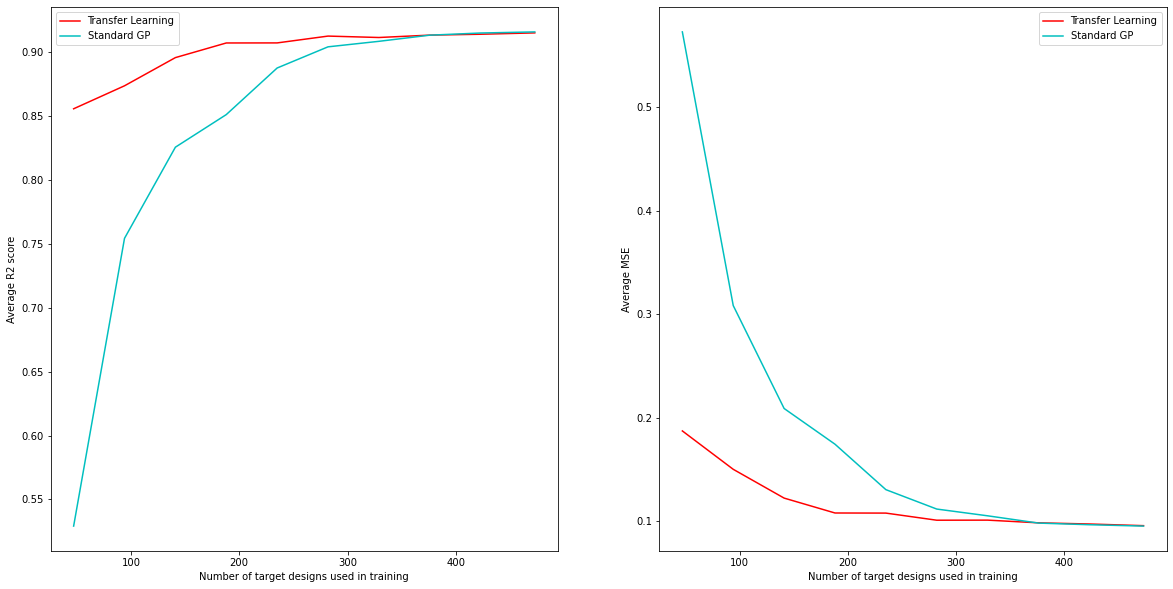

In [30]:
fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = ax

ax1.plot(plot_x_training,y_plot('r2_lin_mf'), c ='r', label='Transfer Learning')
ax1.plot(plot_x_training, y_plot('r2_stand_GP'), c ='c', label='Standard GP')
ax1.set_xlabel('Number of target designs used in training')
ax1.set_ylabel('Average R2 score')
ax1.legend()
    
ax2.plot(plot_x_training, y_plot('mse_lin_mf'), c ='r', label='Transfer Learning')
ax2.plot(plot_x_training, y_plot('mse_stand_GP'), c ='c', label='Standard GP')
ax2.set_xlabel('Number of target designs used in training')
ax2.set_ylabel('Average MSE')
ax2.legend()
#save_fig(f'{name}_ARD_PTB')

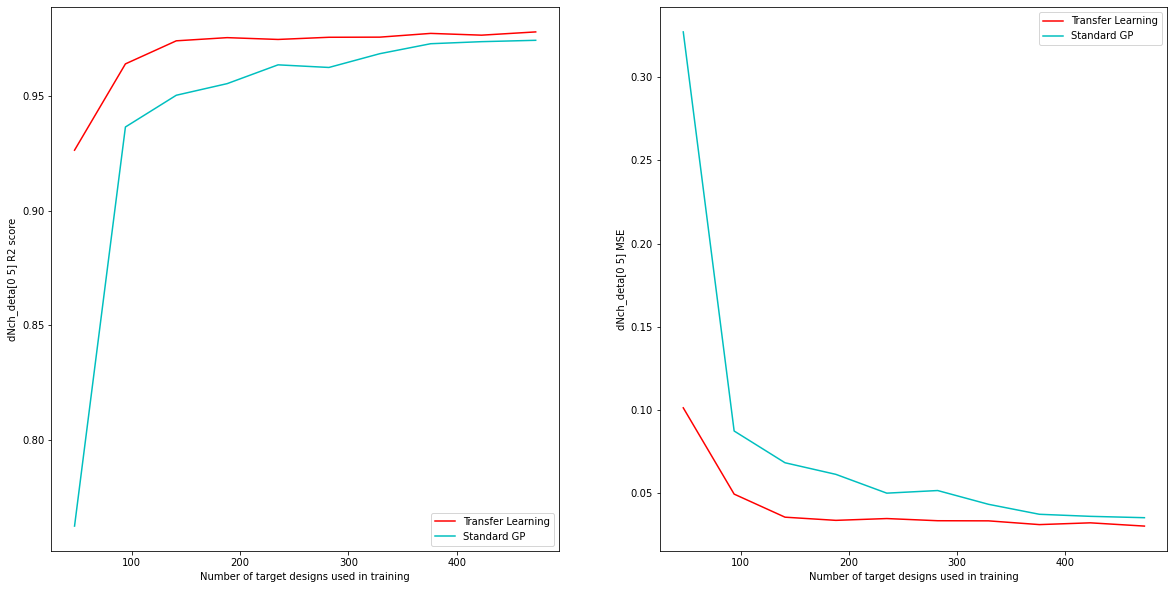

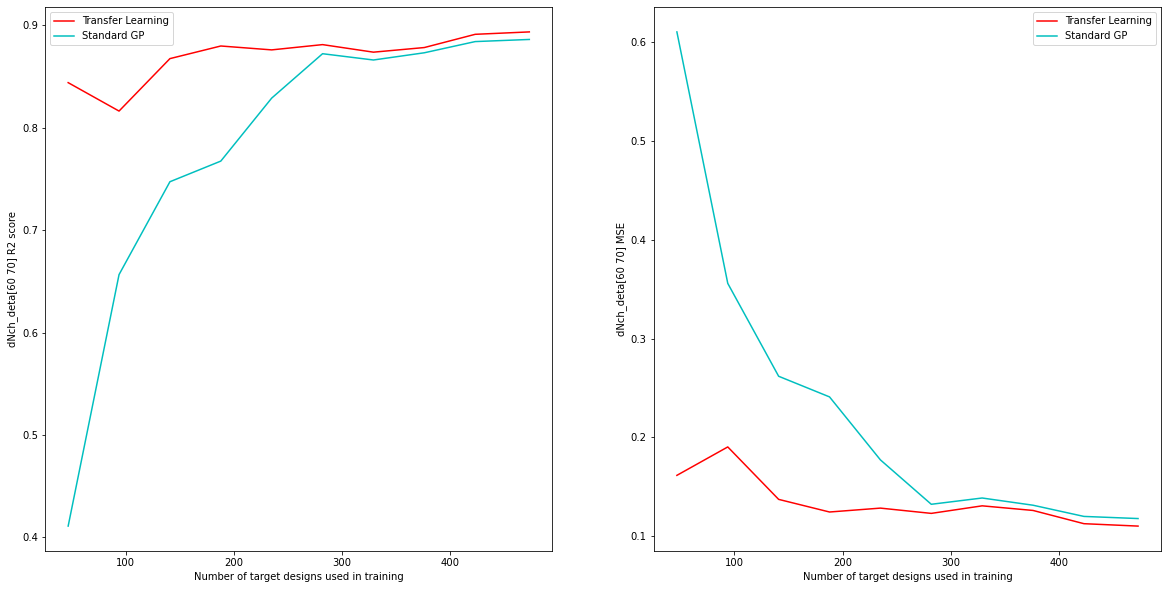

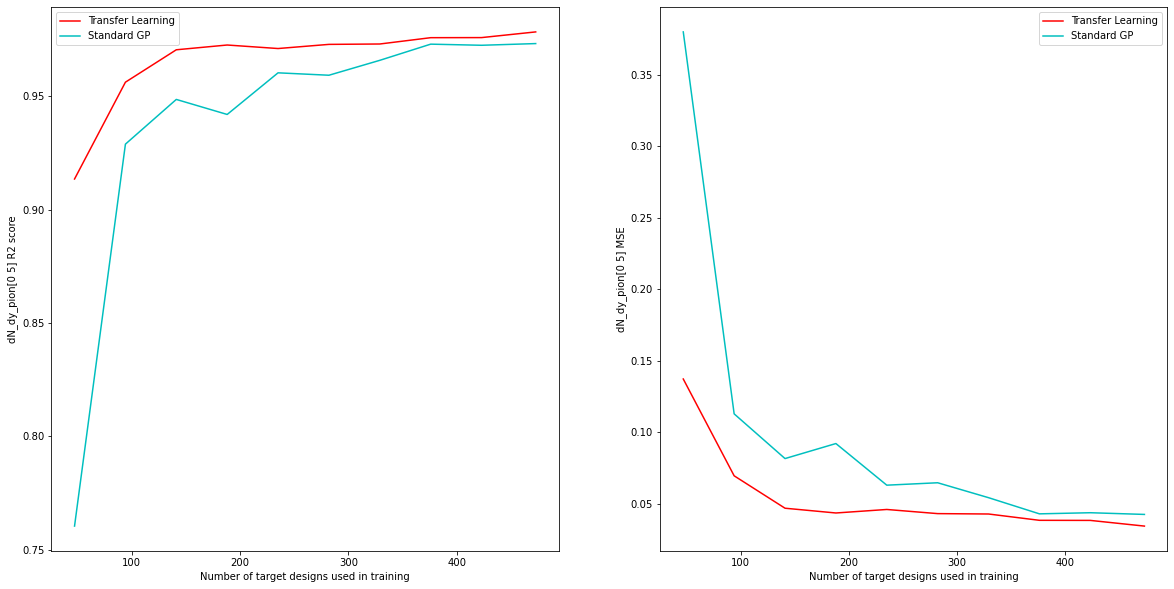

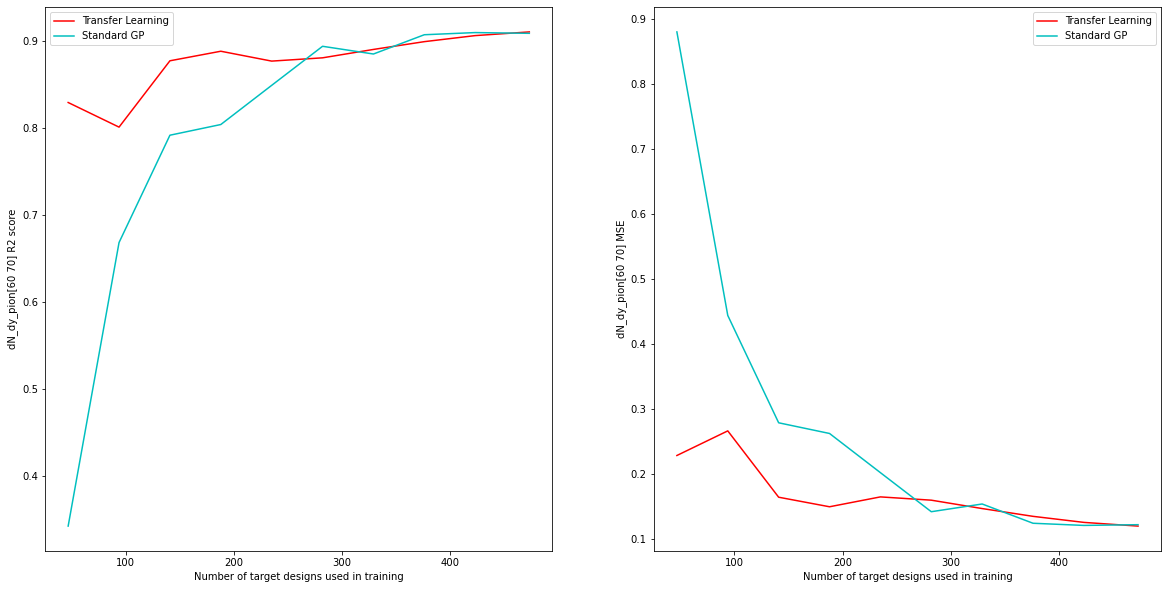

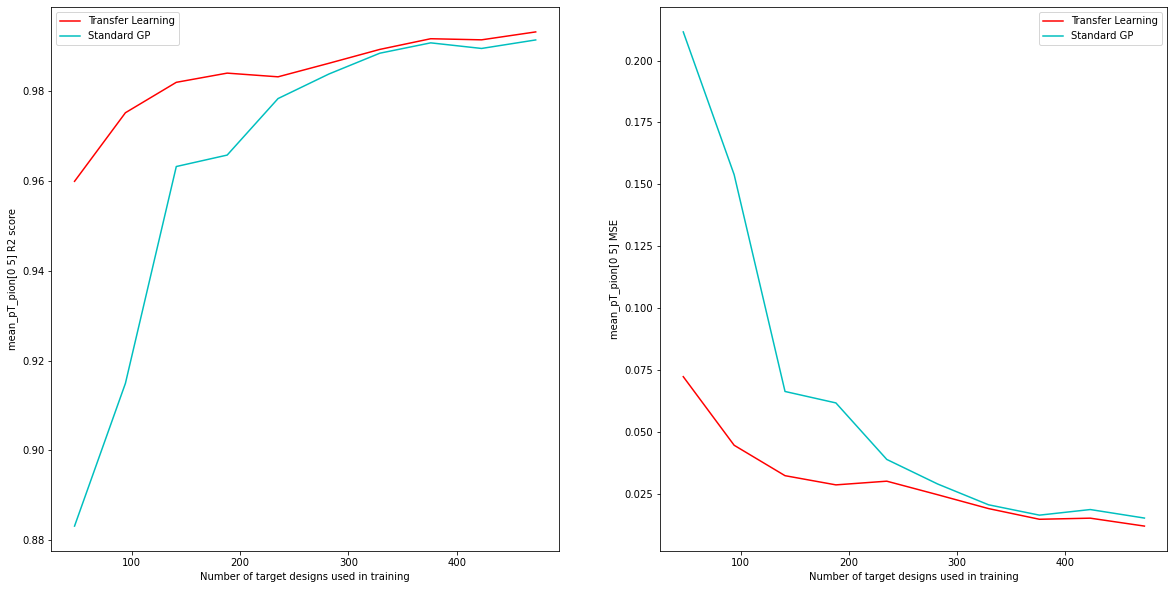

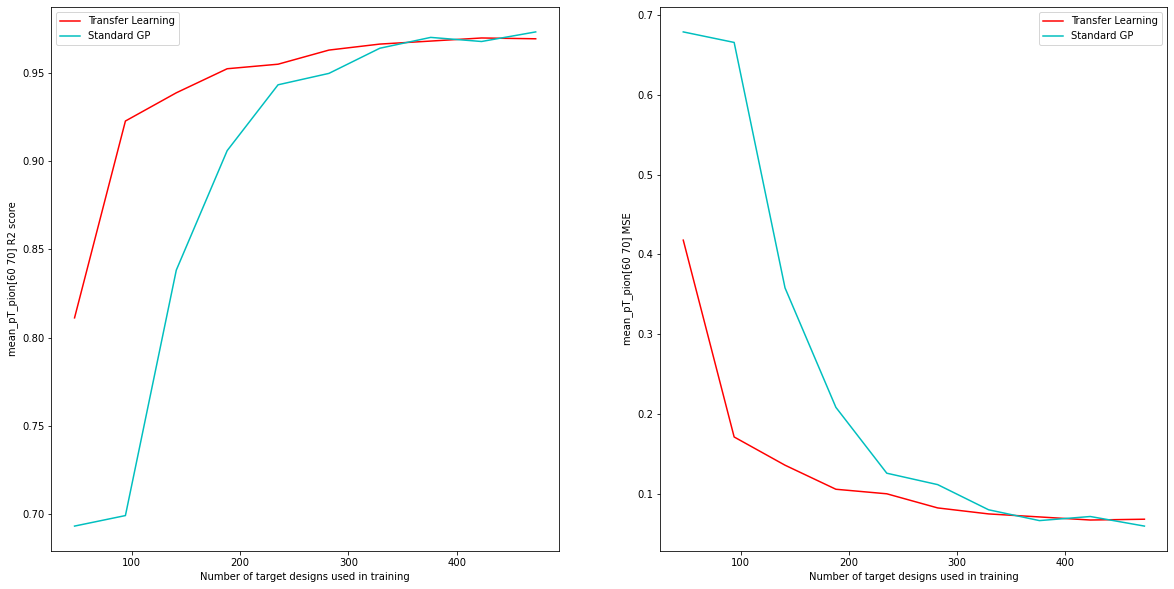

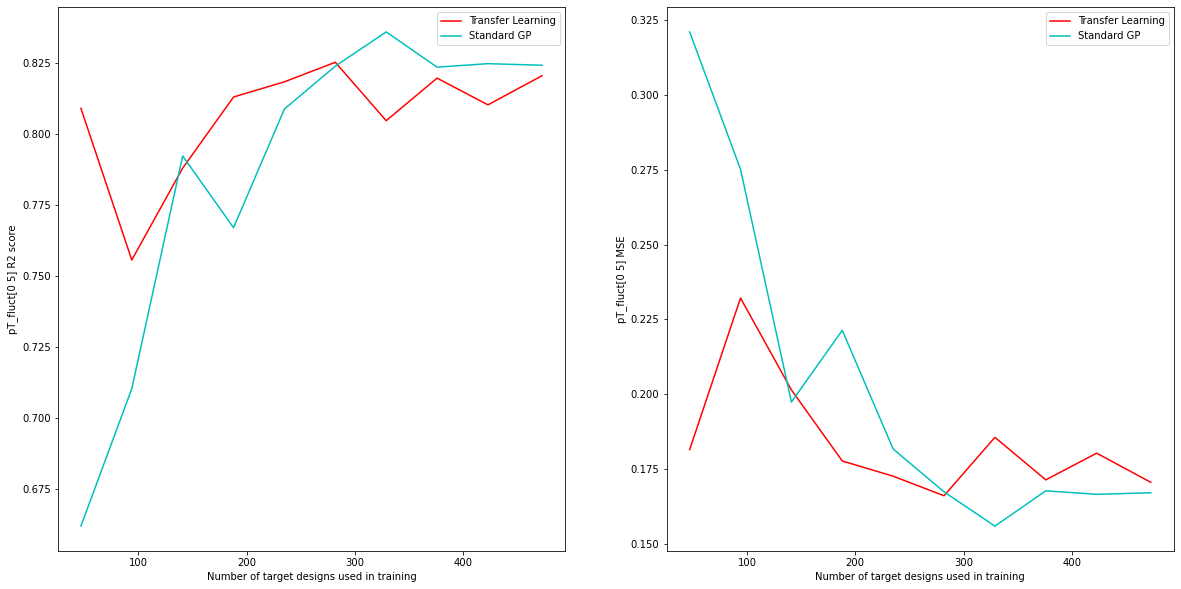

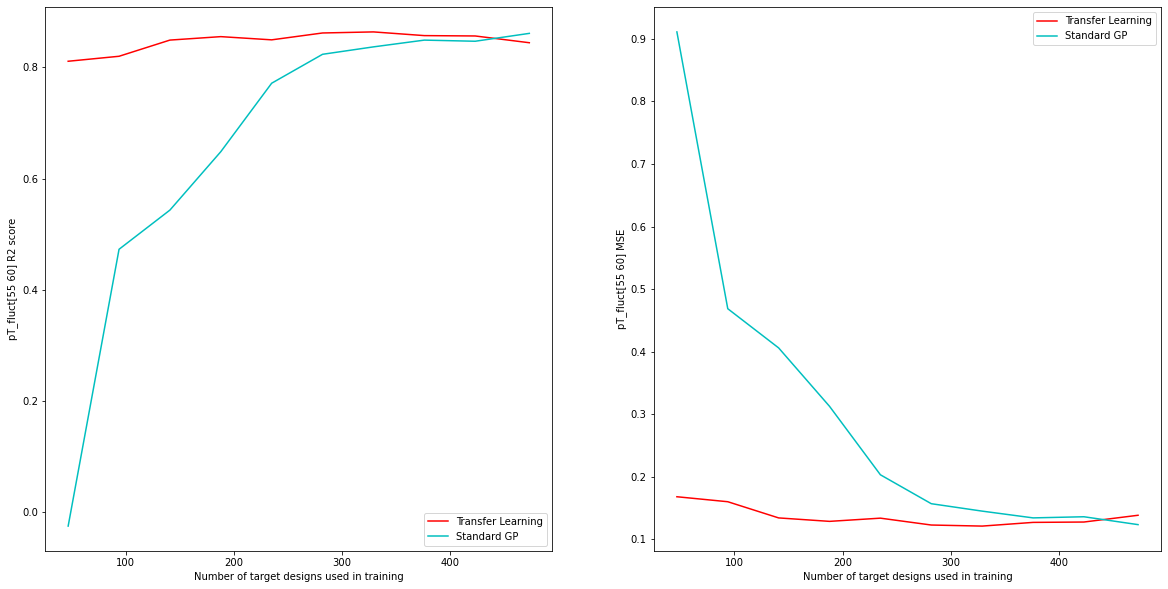

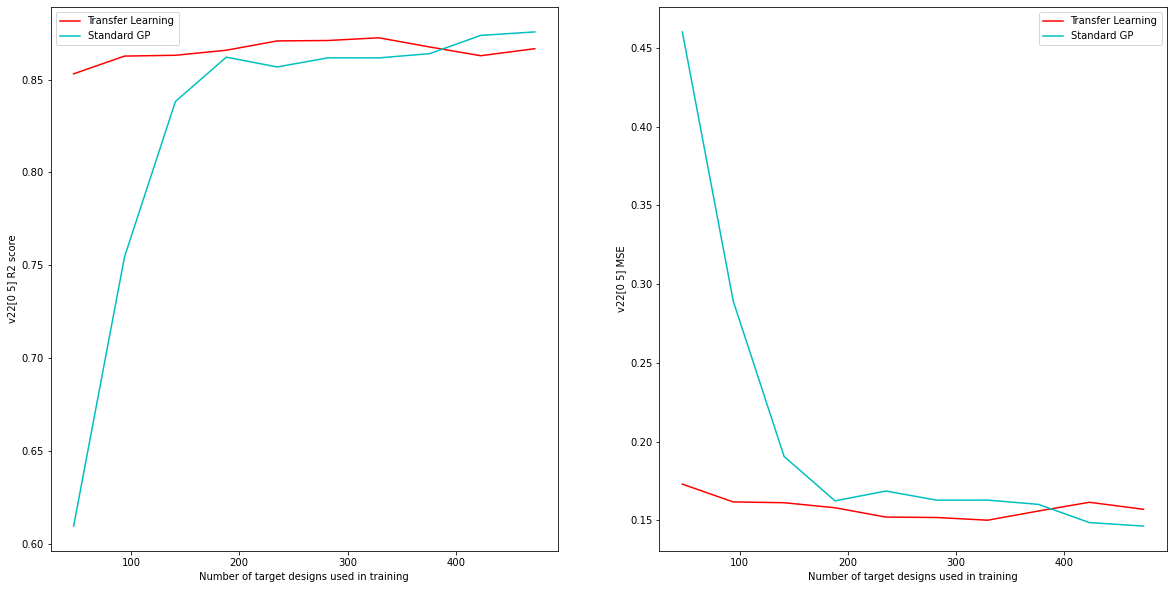

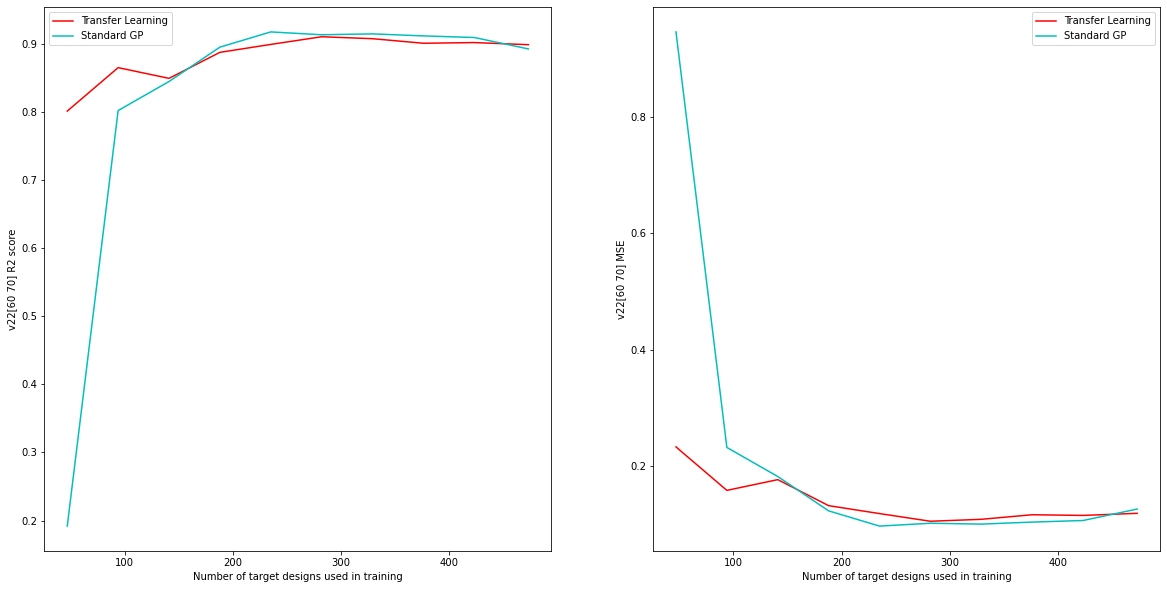

In [31]:
for obs in observables_choosen:
    fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1, ax2 = ax
    ax1.plot(plot_x_training,y_plot_obs('r2_lin_mf',obs), c ='r', label='Transfer Learning')
    ax1.plot(plot_x_training,y_plot_obs('r2_stand_GP',obs),c ='c', label='Standard GP')
    ax1.set_xlabel('Number of target designs used in training')
    ax1.set_ylabel(f'{obs} R2 score')
    ax1.legend()

    ax2.plot(plot_x_training,y_plot_obs('mse_lin_mf',obs), c ='r', label='Transfer Learning')
    ax2.plot(plot_x_training,y_plot_obs('mse_stand_GP',obs), c ='c', label='Standard GP')
    ax2.set_xlabel('Number of target designs used in training')
    ax2.set_ylabel(f'{obs} MSE')
    ax2.legend()
    #save_fig(f'{name}_ARD_PTB')